# Evn*

In [1]:
# imports
import argparse
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm, trange

In [2]:
# 환경 설정
args = {
    # random seed value
    "seed": 1234
}
args = argparse.Namespace(**args)

print(args)

Namespace(seed=1234)


In [3]:
# random seed 설정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [4]:
# gpu 사용량 확인
!nvidia-smi

Wed Mar 16 11:35:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# data dir
data_dir = '/content/drive/MyDrive/문서/강의계획서/삼성전기/삼성전기.20220228/data'
os.listdir(data_dir)

['.ipynb_checkpoints',
 'nsmc',
 'kosts',
 'kowiki',
 'weather',
 'gensim',
 'chat',
 'marcap',
 'passenger']

In [6]:
passenger_dir = os.path.join(data_dir, "passenger")
if not os.path.isdir(passenger_dir):
    os.makedirs(passenger_dir)
os.listdir(passenger_dir)

['airline-passengers.csv',
 'lstm.csv',
 'lstm.hdf5',
 'gru.csv',
 'gru.hdf5',
 'mlp.csv',
 'mlp.hdf5',
 'rnn.hdf5',
 'rnn.csv']

# Data Download

In [ ]:
# !wget https://github.com/jbrownlee/Datasets/raw/master/airline-passengers.csv

In [ ]:
# shutil.move('airline-passengers.csv', passenger_dir)

# Data*

In [7]:
df_all = pd.read_csv(os.path.join(passenger_dir, 'airline-passengers.csv'))
df_all

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [8]:
# 정보 확인
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [9]:
# 문자를 시간으로 변경 후 정보 확인
df_all['Month'] = pd.to_datetime(df_all['Month'])
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [10]:
# 시간순 정렬
df_all.sort_values(by=['Month'], ascending=True, inplace=True)
df_all.reset_index(drop=True, inplace=True)
df_all

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [11]:
# Passengers 정보 확인
df_all.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [12]:
# null check
df_all.isnull().sum(axis=0)

Month         0
Passengers    0
dtype: int64

In [13]:
# 윌별 값 확인
df_all['Month'].value_counts()

1949-01-01    1
1949-02-01    1
1956-09-01    1
1956-10-01    1
1956-11-01    1
             ..
1953-01-01    1
1953-02-01    1
1953-03-01    1
1953-04-01    1
1960-12-01    1
Name: Month, Length: 144, dtype: int64

In [14]:
# 중복 확인
df_all.duplicated(['Month'])
# df_all.duplicated(['Month']).sum()
# df_all.duplicated(['Month']).sum(axis=0)

0      False
1      False
2      False
3      False
4      False
       ...  
139    False
140    False
141    False
142    False
143    False
Length: 144, dtype: bool

In [15]:
# 중복 확인 (첫번째는 남겨 둠)
df_all.duplicated(['Month'], keep='first')
# df_all.duplicated(['Month'], keep='first').sum()
# df_all.duplicated(['Month'], keep='first').sum(axis=0)

0      False
1      False
2      False
3      False
4      False
       ...  
139    False
140    False
141    False
142    False
143    False
Length: 144, dtype: bool

In [16]:
# 중복 제거 (첫번째는 남겨 둠)
df_all.drop_duplicates(['Month'], keep='first', inplace=True)
df_all

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [17]:
# Month를 index로 변환
df_all.set_index(['Month'], inplace=True)
df_all

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [18]:
# 월 기간 검색
df_all.loc['1960-01':'1960-12']

,Passengers
Month,
1960-01-01,417
1960-02-01,391
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508


In [19]:
# 년 기간 검색
df_all.loc['1960']

,Passengers
Month,
1960-01-01,417
1960-02-01,391
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508


In [20]:
# 순서 검색
df_all[10:23]

,Passengers
Month,
1949-11-01,104
1949-12-01,118
1950-01-01,115
1950-02-01,126
1950-03-01,141
1950-04-01,135
1950-05-01,125
1950-06-01,149
1950-07-01,170


In [21]:
# transpose
df_all.T

Month,1949-01-01,1949-02-01,1949-03-01,1949-04-01,1949-05-01,1949-06-01,1949-07-01,1949-08-01,1949-09-01,1949-10-01,...,1960-03-01,1960-04-01,1960-05-01,1960-06-01,1960-07-01,1960-08-01,1960-09-01,1960-10-01,1960-11-01,1960-12-01
Passengers,112,118,132,129,121,135,148,148,136,119,...,419,461,472,535,622,606,508,461,390,432


# Data Understand

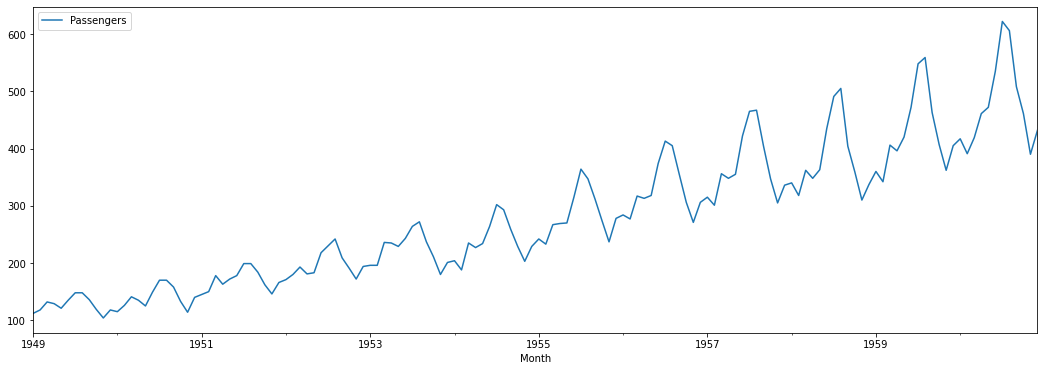

In [ ]:
# plot
df_all.plot(figsize=(18,6))
plt.show()

In [ ]:
# moving 12개월 평균
df_all['move_avg'] = df_all['Passengers'].rolling(window=12).mean()
df_all.head(15)

,Passengers,move_avg
Month,,
1949-01-01,112,NaN
1949-02-01,118,NaN
1949-03-01,132,NaN
1949-04-01,129,NaN
1949-05-01,121,NaN
1949-06-01,135,NaN
1949-07-01,148,NaN
1949-08-01,148,NaN
1949-09-01,136,NaN


In [ ]:
# moving 12개월 표준편차
df_all['move_std'] = df_all['Passengers'].rolling(window=12).std()
df_all.head(15)

,Passengers,move_avg,move_std
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
1949-06-01,135,NaN,NaN
1949-07-01,148,NaN,NaN
1949-08-01,148,NaN,NaN
1949-09-01,136,NaN,NaN


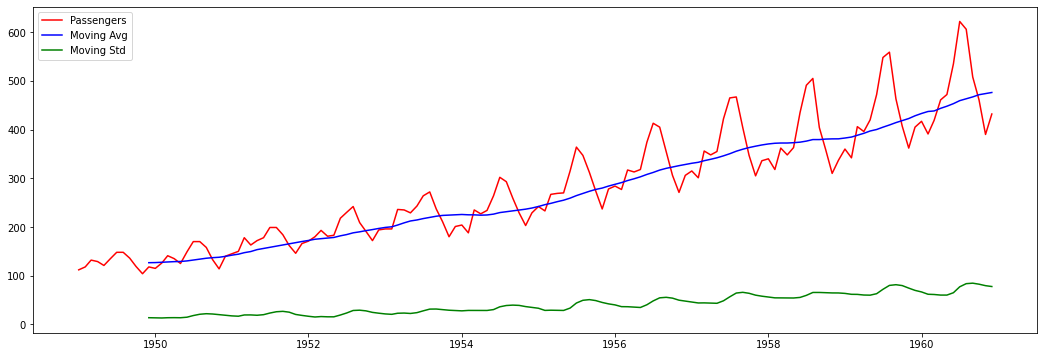

In [ ]:
# moving 그래프 출력
plt.figure(figsize=(18, 6))
plt.plot(df_all['Passengers'], '-r',label='Passengers')
plt.plot(df_all['move_avg'], '-b', label='Moving Avg')
plt.plot(df_all['move_std'], '-g', label = 'Moving Std')
plt.legend()
plt.show()

In [ ]:
# moving avg 차이
df_all['move_dif'] = df_all['Passengers'] - df_all['move_avg']
df_all.head(15)

,Passengers,move_avg,move_std,move_dif
Month,,,,
1949-01-01,112,NaN,NaN,NaN
1949-02-01,118,NaN,NaN,NaN
1949-03-01,132,NaN,NaN,NaN
1949-04-01,129,NaN,NaN,NaN
1949-05-01,121,NaN,NaN,NaN
1949-06-01,135,NaN,NaN,NaN
1949-07-01,148,NaN,NaN,NaN
1949-08-01,148,NaN,NaN,NaN
1949-09-01,136,NaN,NaN,NaN


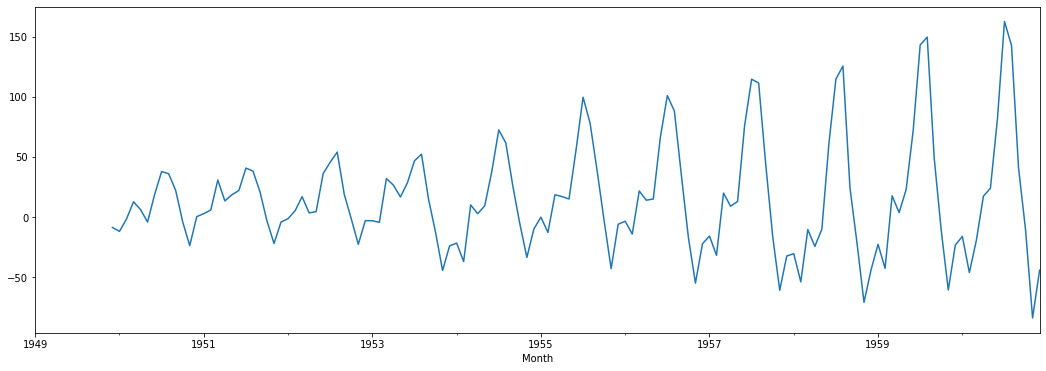

In [ ]:
# plot
df_all['move_dif'].plot(figsize=(18,6))
plt.show()

In [ ]:
df_all['Year'] = df_all.index.year
df_all['_Month'] = df_all.index.month
df_all['Quater'] = df_all.index.quarter

df_all

,Passengers,move_avg,move_std,move_dif,Year,_Month,Quater
Month,,,,,,,
1949-01-01,112,NaN,NaN,NaN,1949,1,1
1949-02-01,118,NaN,NaN,NaN,1949,2,1
1949-03-01,132,NaN,NaN,NaN,1949,3,1
1949-04-01,129,NaN,NaN,NaN,1949,4,2
1949-05-01,121,NaN,NaN,NaN,1949,5,2
...,...,...,...,...,...,...,...
1960-08-01,606,463.333333,83.630500,142.666667,1960,8,3
1960-09-01,508,467.083333,84.617276,40.916667,1960,9,3
1960-10-01,461,471.583333,82.541954,-10.583333,1960,10,4


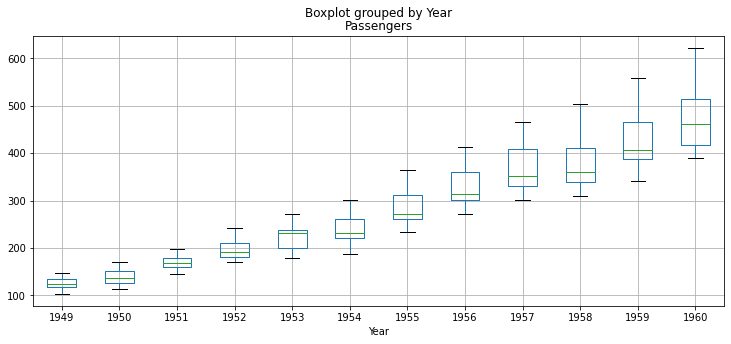

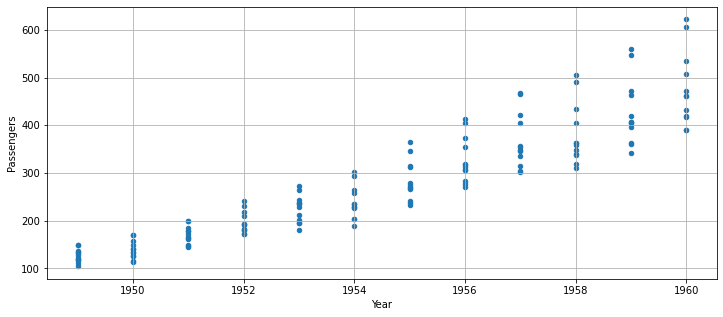

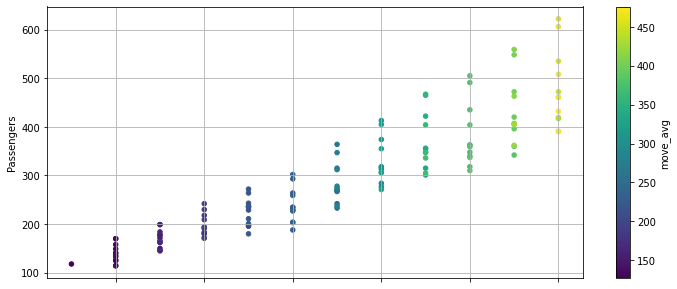

In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

df_all.boxplot(column='Passengers', by='Year', grid=True, figsize=(12,5))
df_all.plot.scatter(y='Passengers', x='Year', grid=True, figsize=(12,5))
df_all.plot.scatter(y='Passengers', x='Year', c='move_avg', grid=True, figsize=(12,5), colormap='viridis')

plt.show()

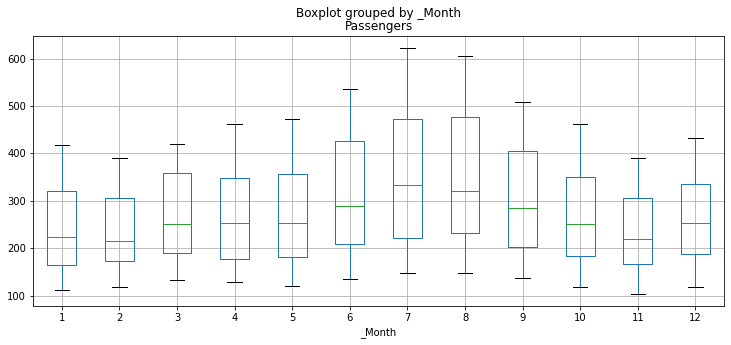

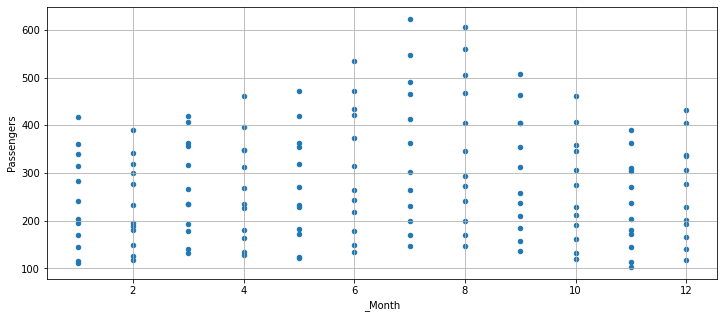

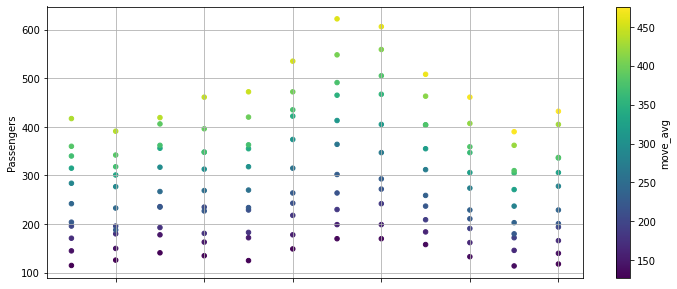

In [ ]:
df_all.boxplot(column='Passengers', by='_Month', grid=True, figsize=(12,5))
df_all.plot.scatter(y='Passengers', x='_Month', grid=True, figsize=(12,5))
df_all.plot.scatter(y='Passengers', x='_Month', c='move_avg', grid=True, figsize=(12,5), colormap='viridis')

plt.show()

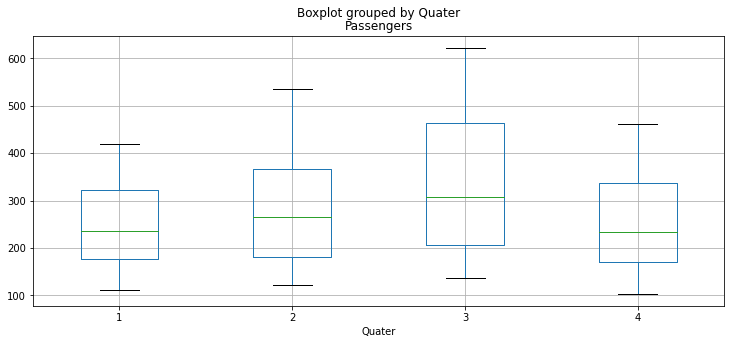

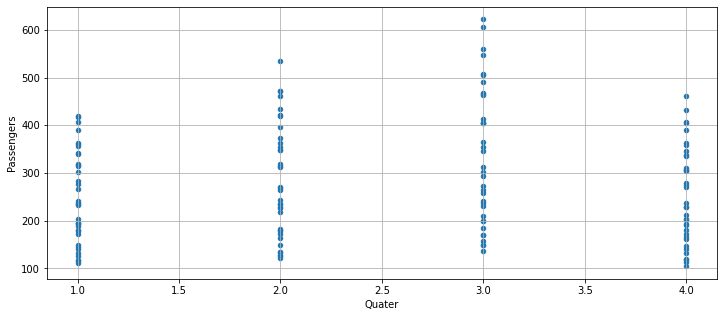

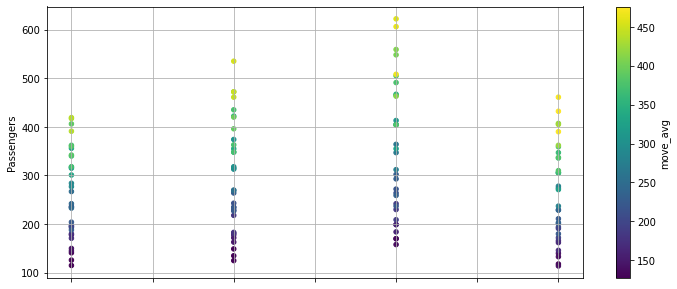

In [ ]:
df_all.boxplot(column='Passengers', by='Quater', grid=True, figsize=(12,5))
df_all.plot.scatter(y='Passengers', x='Quater', grid=True, figsize=(12,5))
df_all.plot.scatter(y='Passengers', x='Quater', c='move_avg', grid=True, figsize=(12,5), colormap='viridis')

plt.show()

# Multi-Layer Perceptron
- 이전 6개의 Passengers를 보고 MLP를 이용해 다음 Passengers 값을 예측

## Config

In [ ]:
args.n_win = 6  # 이전 데이터 수 (입력 수)
args.d_linear = 256
args.n_out = 1
args

Namespace(d_linear=256, n_out=1, n_win=6, seed=1234)

## Train & Test Data 생성

In [ ]:
# ~ 1958 까지 Train / 이후는 Test
index = len(df_all[:'1958'])
index

120

In [ ]:
df_all.iloc[:index]

,Passengers,move_avg,move_std,move_dif,Year,_Month,Quater
Month,,,,,,,
1949-01-01,112,NaN,NaN,NaN,1949,1,1
1949-02-01,118,NaN,NaN,NaN,1949,2,1
1949-03-01,132,NaN,NaN,NaN,1949,3,1
1949-04-01,129,NaN,NaN,NaN,1949,4,2
1949-05-01,121,NaN,NaN,NaN,1949,5,2
...,...,...,...,...,...,...,...
1958-08-01,505,379.500000,65.557054,125.500000,1958,8,3
1958-09-01,404,379.500000,65.557054,24.500000,1958,9,3
1958-10-01,359,380.500000,65.106207,-21.500000,1958,10,4


In [ ]:
df_all.iloc[index:]

,Passengers,move_avg,move_std,move_dif,Year,_Month,Quater
Month,,,,,,,
1959-01-01,360,382.666667,63.627229,-22.666667,1959,1,1
1959-02-01,342,384.666667,61.759553,-42.666667,1959,2,1
1959-03-01,406,388.333333,61.597422,17.666667,1959,3,1
1959-04-01,396,392.333333,60.284678,3.666667,1959,4,2
1959-05-01,420,397.083333,60.008270,22.916667,1959,5,2
1959-06-01,472,400.166667,63.009138,71.833333,1959,6,2
1959-07-01,548,404.916667,71.987951,143.083333,1959,7,3
1959-08-01,559,409.416667,80.049369,149.583333,1959,8,3
1959-09-01,463,414.333333,81.485451,48.666667,1959,9,3


In [ ]:
inputs = []
labels = []
n_win = args.n_win

for i in range(0, 10):
    x = df_all.iloc[i:i + n_win]['Passengers'].to_numpy().astype(float)
    y = df_all.iloc[i + n_win]['Passengers']
    inputs.append(x)
    labels.append(y)
inputs = np.array(inputs)
labels = np.array(labels)

inputs, labels

(array([[112., 118., 132., 129., 121., 135.],
        [118., 132., 129., 121., 135., 148.],
        [132., 129., 121., 135., 148., 148.],
        [129., 121., 135., 148., 148., 136.],
        [121., 135., 148., 148., 136., 119.],
        [135., 148., 148., 136., 119., 104.],
        [148., 148., 136., 119., 104., 118.],
        [148., 136., 119., 104., 118., 115.],
        [136., 119., 104., 118., 115., 126.],
        [119., 104., 118., 115., 126., 141.]]),
 array([148., 148., 136., 119., 104., 118., 115., 126., 141., 135.]))

In [ ]:
# 데이터 생성
def make_data(df, start, end, n_win=12):
    inputs = []
    labels = []
    #########################
    for i in range(start, end):
        x = df_all.iloc[i:i + n_win]['Passengers'].to_numpy().astype(float)
        y = df_all.iloc[i + n_win]['Passengers']
        inputs.append(x)
        labels.append(y)
    #########################
    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

In [ ]:
# train data 생성
train_inputs, train_labels = make_data(df_all, 0, index - args.n_win, n_win=args.n_win)
train_inputs, train_labels

(array([[112., 118., 132., 129., 121., 135.],
        [118., 132., 129., 121., 135., 148.],
        [132., 129., 121., 135., 148., 148.],
        [129., 121., 135., 148., 148., 136.],
        [121., 135., 148., 148., 136., 119.],
        [135., 148., 148., 136., 119., 104.],
        [148., 148., 136., 119., 104., 118.],
        [148., 136., 119., 104., 118., 115.],
        [136., 119., 104., 118., 115., 126.],
        [119., 104., 118., 115., 126., 141.],
        [104., 118., 115., 126., 141., 135.],
        [118., 115., 126., 141., 135., 125.],
        [115., 126., 141., 135., 125., 149.],
        [126., 141., 135., 125., 149., 170.],
        [141., 135., 125., 149., 170., 170.],
        [135., 125., 149., 170., 170., 158.],
        [125., 149., 170., 170., 158., 133.],
        [149., 170., 170., 158., 133., 114.],
        [170., 170., 158., 133., 114., 140.],
        [170., 158., 133., 114., 140., 145.],
        [158., 133., 114., 140., 145., 150.],
        [133., 114., 140., 145., 1

In [ ]:
# test data 생성
test_inputs, test_labels = make_data(df_all, index - args.n_win, len(df_all) - args.n_win, n_win=args.n_win)
test_inputs, test_labels

(array([[491., 505., 404., 359., 310., 337.],
        [505., 404., 359., 310., 337., 360.],
        [404., 359., 310., 337., 360., 342.],
        [359., 310., 337., 360., 342., 406.],
        [310., 337., 360., 342., 406., 396.],
        [337., 360., 342., 406., 396., 420.],
        [360., 342., 406., 396., 420., 472.],
        [342., 406., 396., 420., 472., 548.],
        [406., 396., 420., 472., 548., 559.],
        [396., 420., 472., 548., 559., 463.],
        [420., 472., 548., 559., 463., 407.],
        [472., 548., 559., 463., 407., 362.],
        [548., 559., 463., 407., 362., 405.],
        [559., 463., 407., 362., 405., 417.],
        [463., 407., 362., 405., 417., 391.],
        [407., 362., 405., 417., 391., 419.],
        [362., 405., 417., 391., 419., 461.],
        [405., 417., 391., 419., 461., 472.],
        [417., 391., 419., 461., 472., 535.],
        [391., 419., 461., 472., 535., 622.],
        [419., 461., 472., 535., 622., 606.],
        [461., 472., 535., 622., 6

## Modeling

In [ ]:
# test inputs & labels
inputs = np.random.randint(100, 200, (2, args.n_win)).astype(float)
labels = np.random.randint(100, 200, (2,)).astype(float)
inputs, labels

(array([[183., 136., 162., 144., 146., 172.],
        [125., 167., 141., 120., 163., 192.]]), array([151., 171.]))

In [ ]:
dens_1 = tf.keras.layers.Dense(args.d_linear)
hidden = dens_1(inputs)
hidden.shape

TensorShape([2, 256])

In [ ]:
dens_o = tf.keras.layers.Dense(args.n_out)
y_pred = dens_o(hidden)
y_pred

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-1.5441017],
       [-3.897152 ]], dtype=float32)>

In [ ]:
def build_model(args):
    inputs = tf.keras.layers.Input((args.n_win,))
    #########################
    dens_1 = tf.keras.layers.Dense(args.d_linear)
    hidden = dens_1(inputs)

    dens_o = tf.keras.layers.Dense(args.n_out)
    y_pred = dens_o(hidden)
    #########################
    model = tf.keras.Model(inputs=inputs, outputs=y_pred)
    return model

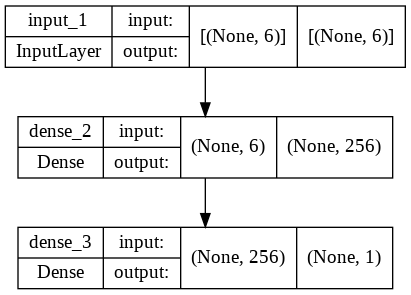

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict(train_inputs[:4])

array([[-7.7836494],
       [-8.421046 ],
       [-5.693928 ],
       [-6.4452553]], dtype=float32)

In [ ]:
model.predict(test_inputs[:4])

array([[ 3.3707352],
       [22.175974 ],
       [ 1.168272 ],
       [-7.262932 ]], dtype=float32)

## Train

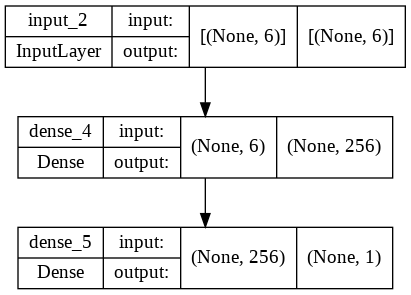

In [ ]:
set_seed(args.seed)
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="mse", optimizer="adam")

In [ ]:
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(passenger_dir, "mlp.hdf5"),
                                                  monitor='val_loss',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="min",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(passenger_dir, "mlp.csv"))

In [ ]:
history = model.fit(train_inputs, train_labels,
                    epochs=250,
                    batch_size=8,
                    validation_data=(test_inputs, test_labels),
                    callbacks=[save_weights, csv_logger])

Epoch 1/250
 9/15 [=================>............] - ETA: 0s - loss: 13971.5342 
Epoch 1: val_loss improved from inf to 11920.99219, saving model to /content/drive/MyDrive/문서/강의계획서/삼성전기/삼성전기.20220228/data/passenger/mlp.hdf5
15/15 [==============================] - 2s 52ms/step - loss: 11523.3516 - val_loss: 11920.9922
Epoch 2/250
15/15 [==============================] - ETA: 0s - loss: 2344.0764
Epoch 2: val_loss improved from 11920.99219 to 6850.33838, saving model to /content/drive/MyDrive/문서/강의계획서/삼성전기/삼성전기.20220228/data/passenger/mlp.hdf5
15/15 [==============================] - 0s 17ms/step - loss: 2344.0764 - val_loss: 6850.3384
Epoch 3/250
11/15 [=====================>........] - ETA: 0s - loss: 1781.1073
Epoch 3: val_loss improved from 6850.33838 to 5557.74756, saving model to /content/drive/MyDrive/문서/강의계획서/삼성전기/삼성전기.20220228/data/passenger/mlp.hdf5
15/15 [==============================] - 0s 12ms/step - l

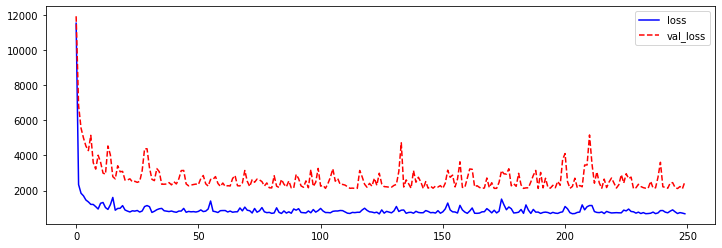

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 1, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.legend()

plt.show()

## 평가

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(passenger_dir, "mlp.hdf5"))

In [ ]:
model.compile(loss="mse", optimizer="adam")

In [ ]:
model.evaluate(test_inputs, test_labels)

1/1 [==============================] - 0s 102ms/step - loss: 2106.8069


2106.806884765625

In [ ]:
# train 예측
train_preds = model.predict(train_inputs)
train_preds = train_preds.squeeze()
train_preds

array([139.18233 , 153.50658 , 149.86476 , 130.85959 , 116.06274 ,
       107.0467  , 131.76672 , 120.86252 , 135.22514 , 142.19037 ,
       133.98233 , 122.084724, 156.01503 , 176.85976 , 170.22395 ,
       149.33725 , 125.805405, 117.358696, 158.07727 , 153.42647 ,
       156.41968 , 179.35269 , 155.80714 , 175.94244 , 174.30536 ,
       209.7763  , 195.25009 , 179.65718 , 155.88646 , 149.79602 ,
       182.58717 , 179.2414  , 187.03017 , 191.53696 , 176.62254 ,
       184.74689 , 226.71638 , 233.30217 , 242.2783  , 190.61684 ,
       190.48451 , 172.37119 , 216.30035 , 202.1101  , 201.88866 ,
       242.44795 , 230.45206 , 227.08699 , 239.10193 , 270.6747  ,
       273.73026 , 223.79376 , 206.41202 , 179.94052 , 226.1863  ,
       213.7198  , 193.06828 , 245.98543 , 220.56549 , 240.44728 ,
       260.51544 , 311.22406 , 282.57248 , 242.97913 , 219.90276 ,
       209.58763 , 254.52116 , 254.06888 , 236.26707 , 271.25665 ,
       263.79086 , 272.34897 , 319.05347 , 371.0279  , 333.106

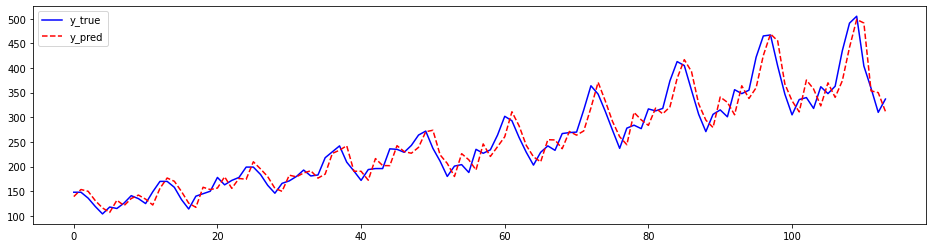

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(train_labels, 'b-', label='y_true')
plt.plot(train_preds, 'r--', label='y_pred')
plt.legend()
plt.show()

In [ ]:
rmse = tf.sqrt(tf.keras.losses.MSE(train_labels, train_preds))
rmse

<tf.Tensor: shape=(), dtype=float32, numpy=25.801706>

In [ ]:
rmse = np.sqrt(np.mean(np.square(train_labels - train_preds)))
rmse

25.801706484350852

In [ ]:
# test 예측
test_preds = model.predict(test_inputs)
test_preds = test_preds.squeeze()
test_preds

array([386.3977 , 379.86017, 347.3386 , 417.79395, 380.44006, 429.9187 ,
       466.1994 , 561.9435 , 540.19714, 418.22305, 388.83463, 367.2916 ,
       457.1282 , 434.07605, 393.4888 , 419.34372, 468.2444 , 475.08066,
       539.7583 , 623.05005, 581.43524, 462.9697 , 444.50766, 394.9139 ],
      dtype=float32)

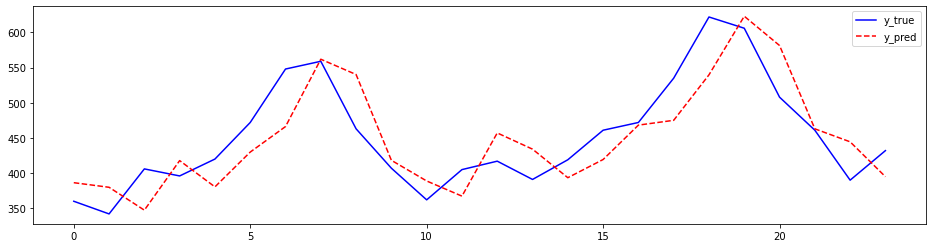

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(test_labels, 'b-', label='y_true')
plt.plot(test_preds, 'r--', label='y_pred')
plt.legend()
plt.show()

In [ ]:
rmse = tf.sqrt(tf.keras.losses.MSE(test_labels, test_preds))
rmse

<tf.Tensor: shape=(), dtype=float32, numpy=45.899967>

In [ ]:
rmse = np.sqrt(np.mean(np.square(test_labels - test_preds)))
rmse

45.89996722842611

# RNN feature 1
- 이전 6개의 Passengers를 보고 RNN을 이용해 다음 Passengers 값을 예측

## Config

In [ ]:
args.n_win = 6  # 이전 데이터 수 (입력 수)
args.d_rnn = 512
args.n_out = 1
args

Namespace(d_linear=256, d_rnn=512, n_out=1, n_win=6, seed=1234)

## Train & Test Data 생성

In [ ]:
# ~ 1958 까지 Train / 이후는 Test
index = len(df_all[:'1958'])
index

120

In [ ]:
inputs = []
labels = []
n_win = 5

for i in range(0, 10):
    x = df_all.iloc[i:i + n_win][['Passengers']].to_numpy().astype(float)
    y = df_all.iloc[i + n_win]['Passengers']
    inputs.append(x)
    labels.append(y)
inputs = np.array(inputs)
labels = np.array(labels)

inputs.shape, labels

((10, 5, 1),
 array([135., 148., 148., 136., 119., 104., 118., 115., 126., 141.]))

In [ ]:
# 데이터 생성
def make_data(df, start, end, n_win=12):
    inputs = []
    labels = []
    #########################
    for i in range(start, end):
        x = df_all.iloc[i:i + n_win][['Passengers']].to_numpy().astype(float)
        y = df_all.iloc[i + n_win]['Passengers']
        inputs.append(x)
        labels.append(y)
    #########################
    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

In [ ]:
# train data 생성
train_inputs, train_labels = make_data(df_all, 0, index - args.n_win, n_win=args.n_win)
train_inputs.shape, train_labels.shape

((114, 6, 1), (114,))

In [ ]:
# test data 생성
test_inputs, test_labels = make_data(df_all, index - args.n_win, len(df_all) - args.n_win, n_win=args.n_win)
test_inputs.shape, test_labels.shape

((24, 6, 1), (24,))

## Modeling

In [ ]:
# test inputs & labels
inputs = np.random.randint(100, 200, (2, 5, 1)).astype(float)
labels = np.random.randint(100, 200, (2,)).astype(float)
inputs, labels

(array([[[147.],
         [183.],
         [138.],
         [153.],
         [176.]],
 
        [[124.],
         [115.],
         [149.],
         [123.],
         [126.]]]), array([130., 143.]))

In [ ]:
lstm_1 = tf.keras.layers.LSTM(units=args.d_rnn)
hidden = lstm_1(inputs)
hidden.shape

TensorShape([2, 512])

In [ ]:
dens_o = tf.keras.layers.Dense(args.n_out)
y_pred = dens_o(hidden)
y_pred

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 0.02936253],
       [-0.07685256]], dtype=float32)>

In [ ]:
def build_model(args):
    inputs = tf.keras.layers.Input((args.n_win, 1))

    dens_1 = tf.keras.layers.Dense(args.d_rnn)
    hidden = dens_1(inputs)

    lstm_1 = tf.keras.layers.LSTM(args.d_rnn)
    hidden = lstm_1(hidden)

    dens_o = tf.keras.layers.Dense(args.n_out)
    y_pred = dens_o(hidden)

    model = tf.keras.Model(inputs=inputs, outputs=y_pred)
    return model

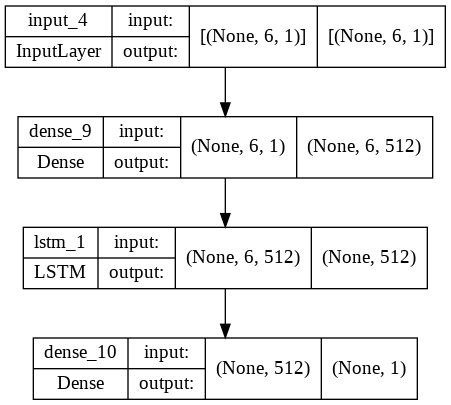

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict(train_inputs[:4])

array([[-1.167412 ],
       [-1.179914 ],
       [-1.1735086],
       [-1.1545589]], dtype=float32)

In [ ]:
model.predict(test_inputs[:4])

array([[-1.0798104],
       [-1.0880868],
       [-1.0943999],
       [-1.0965286]], dtype=float32)

## Train

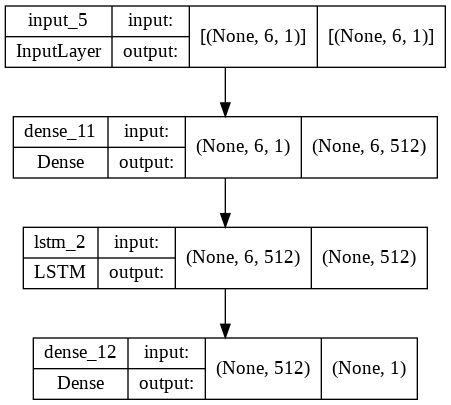

In [ ]:
set_seed(args.seed)
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="mse", optimizer="adam")

In [ ]:
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(passenger_dir, "rnn.hdf5"),
                                                  monitor='val_loss',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="min",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(passenger_dir, "rnn.csv"))

In [ ]:
history = model.fit(train_inputs, train_labels,
                    epochs=250,
                    batch_size=8,
                    validation_data=(test_inputs, test_labels),
                    callbacks=[save_weights, csv_logger])

Epoch 1/250
13/15 [=========================>....] - ETA: 0s - loss: 66834.9219
Epoch 1: val_loss improved from inf to 194520.92188, saving model to /content/drive/MyDrive/문서/강의계획서/삼성전기/삼성전기.20220228/data/passenger/rnn.hdf5
15/15 [==============================] - 3s 69ms/step - loss: 65638.3125 - val_loss: 194520.9219
Epoch 2/250
13/15 [=========================>....] - ETA: 0s - loss: 62540.2344
Epoch 2: val_loss improved from 194520.92188 to 191086.42188, saving model to /content/drive/MyDrive/문서/강의계획서/삼성전기/삼성전기.20220228/data/passenger/rnn.hdf5
15/15 [==============================] - 0s 16ms/step - loss: 62857.9570 - val_loss: 191086.4219
Epoch 3/250
13/15 [=========================>....] - ETA: 0s - loss: 57341.6055
Epoch 3: val_loss improved from 191086.42188 to 187728.26562, saving model to /content/drive/MyDrive/문서/강의계획서/삼성전기/삼성전기.20220228/data/passenger/rnn.hdf5
15/15 [==============================] - 0s 

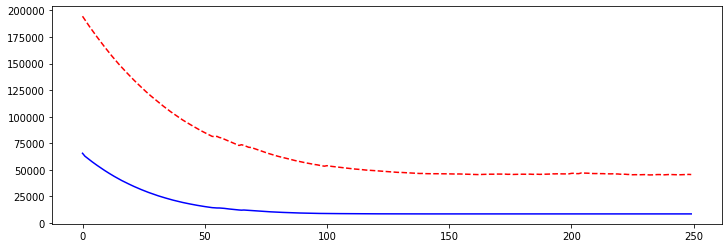

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 1, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.show()

## 평가

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(passenger_dir, "rnn.hdf5"))

In [ ]:
model.compile(loss="mse", optimizer="adam")

In [ ]:
model.evaluate(test_inputs, test_labels)

1/1 [==============================] - 1s 522ms/step - loss: 45256.3594


45256.359375

In [ ]:
# train 예측
train_preds = model.predict(train_inputs)
train_preds = train_preds.squeeze()
train_preds

array([253.05243, 253.05243, 253.05243, 253.05243, 253.05243, 253.05243,
       253.05243, 253.05243, 253.05243, 253.05243, 253.05243, 253.05243,
       253.05243, 253.05243, 253.05243, 253.05243, 253.05243, 253.05243,
       253.05243, 253.05243, 253.05243, 253.05243, 253.05243, 253.05243,
       253.05243, 253.05243, 253.05243, 253.05243, 253.05243, 253.05243,
       253.05243, 253.05243, 253.05243, 253.05243, 253.05243, 253.05243,
       253.05243, 253.05243, 253.05243, 253.05243, 253.05243, 253.05243,
       253.05243, 253.05243, 253.05243, 253.05243, 253.05243, 253.05243,
       253.05243, 253.05243, 253.05243, 253.05243, 253.05243, 253.05243,
       253.05243, 253.05243, 253.05243, 253.05243, 253.05243, 253.05243,
       253.05243, 253.05243, 253.05243, 253.05243, 253.05243, 253.05243,
       253.05243, 253.05243, 253.05243, 253.05243, 253.05243, 253.05243,
       253.05243, 253.05243, 253.05243, 253.05243, 253.05243, 253.05243,
       253.05243, 253.05243, 253.05243, 253.05243, 

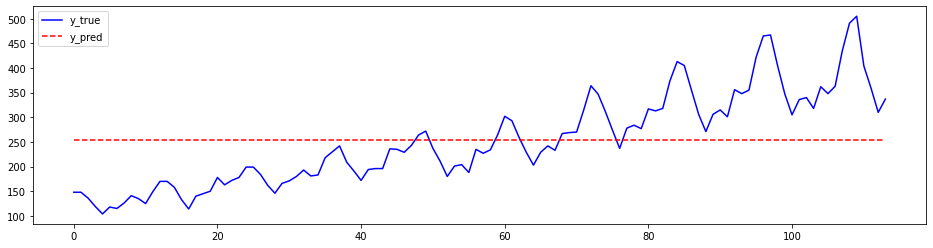

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(train_labels, 'b-', label='y_true')
plt.plot(train_preds, 'r--', label='y_pred')
plt.legend()
plt.show()

In [ ]:
rmse = tf.sqrt(tf.keras.losses.MSE(train_labels, train_preds))
rmse

<tf.Tensor: shape=(), dtype=float32, numpy=92.681244>

In [ ]:
rmse = np.sqrt(np.mean(np.square(train_labels - train_preds)))
rmse

92.6812450054875

In [ ]:
# test 예측
test_preds = model.predict(test_inputs)
test_preds = test_preds.squeeze()
test_preds

array([253.05243, 253.05243, 253.05243, 253.05243, 253.05243, 253.05243,
       253.05243, 253.05243, 253.05243, 253.05243, 253.05243, 253.05243,
       253.05243, 253.05243, 253.05243, 253.05243, 253.05243, 253.05243,
       253.05243, 253.05243, 253.05243, 253.05243, 253.05243, 253.05243],
      dtype=float32)

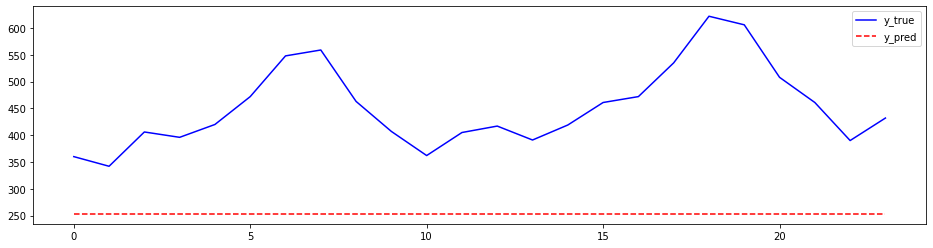

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(test_labels, 'b-', label='y_true')
plt.plot(test_preds, 'r--', label='y_pred')
plt.legend()
plt.show()

In [ ]:
rmse = tf.sqrt(tf.keras.losses.MSE(test_labels, test_preds))
rmse

<tf.Tensor: shape=(), dtype=float32, numpy=212.73543>

In [ ]:
rmse = np.sqrt(np.mean(np.square(test_labels - test_preds)))
rmse

212.7354218576029

# RNN feature 1 (sacle)
- 입력을 min, max scaling 후 
- 이전 12개의 Passengers를 보고 RNN을 이용해 다음 Passengers 값을 예측

## Config

In [ ]:
args.n_win = 6  # 이전 데이터 수 (입력 수)
args.d_rnn = 512
args.n_out = 1
args

Namespace(d_linear=256, d_rnn=512, n_out=1, n_win=6, seed=1234)

## Min Max Scaling

In [ ]:
class MinMaxScaler():
    def __init__(self, min_val, max_val):
        assert (max_val > min_val)
        self.min_val = min_val
        self.max_val = max_val

    def scale_value(self, val):
        return (val - self.min_val) / (self.max_val - self.min_val)

    def inv_scale_value(self, scaled_val):
        return self.min_val + scaled_val * (self.max_val - self.min_val)

In [ ]:
min_val = df_all['Passengers'].min()
max_val = df_all['Passengers'].max()
min_val, max_val

(104, 622)

In [ ]:
df_all['Passengers']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: Passengers, Length: 144, dtype: int64

In [ ]:
# 스케일 적용
(df_all['Passengers'] - min_val) / (max_val - min_val)

Month
1949-01-01    0.015444
1949-02-01    0.027027
1949-03-01    0.054054
1949-04-01    0.048263
1949-05-01    0.032819
                ...   
1960-08-01    0.969112
1960-09-01    0.779923
1960-10-01    0.689189
1960-11-01    0.552124
1960-12-01    0.633205
Name: Passengers, Length: 144, dtype: float64

In [ ]:
scaler_dic = {}
scaler_dic['Passengers'] = MinMaxScaler(min_val, max_val)
scaler_dic['Passengers'].scale_value(df_all['Passengers'])

Month
1949-01-01    0.015444
1949-02-01    0.027027
1949-03-01    0.054054
1949-04-01    0.048263
1949-05-01    0.032819
                ...   
1960-08-01    0.969112
1960-09-01    0.779923
1960-10-01    0.689189
1960-11-01    0.552124
1960-12-01    0.633205
Name: Passengers, Length: 144, dtype: float64

In [ ]:
df_all['Passengers_scale'] = scaler_dic['Passengers'].scale_value(df_all['Passengers'])
df_all

,Passengers,move_avg,move_std,move_dif,Year,_Month,Quater,Passengers_scale
Month,,,,,,,,
1949-01-01,112,NaN,NaN,NaN,1949,1,1,0.015444
1949-02-01,118,NaN,NaN,NaN,1949,2,1,0.027027
1949-03-01,132,NaN,NaN,NaN,1949,3,1,0.054054
1949-04-01,129,NaN,NaN,NaN,1949,4,2,0.048263
1949-05-01,121,NaN,NaN,NaN,1949,5,2,0.032819
...,...,...,...,...,...,...,...,...
1960-08-01,606,463.333333,83.630500,142.666667,1960,8,3,0.969112
1960-09-01,508,467.083333,84.617276,40.916667,1960,9,3,0.779923
1960-10-01,461,471.583333,82.541954,-10.583333,1960,10,4,0.689189


In [ ]:
scaler_dic['Passengers'].inv_scale_value(df_all['Passengers_scale'])

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Name: Passengers_scale, Length: 144, dtype: float64

## Train & Test Data 생성

In [ ]:
# ~ 1958 까지 Train / 이후는 Test
index = len(df_all[:'1958'])
index

120

In [ ]:
inputs = []
labels = []
n_win = 5

for i in range(0, 10):
    x = df_all.iloc[i:i + n_win][['Passengers_scale']].to_numpy().astype(float)
    y = df_all.iloc[i + n_win]['Passengers_scale']
    inputs.append(x)
    labels.append(y)
inputs = np.array(inputs)
labels = np.array(labels)

inputs.shape, labels

((10, 5, 1), array([0.05984556, 0.08494208, 0.08494208, 0.06177606, 0.02895753,
        0.        , 0.02702703, 0.02123552, 0.04247104, 0.07142857]))

In [ ]:
# 데이터 생성
def make_data(df, start, end, n_win=12):
    inputs = []
    labels = []
    #########################
    for i in range(start, end):
        x = df.iloc[i:i + n_win][['Passengers_scale']].to_numpy()
        y = df.iloc[i + n_win]['Passengers_scale']
        inputs.append(x)
        labels.append(y)
    #########################
    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

In [ ]:
# train data 생성
train_inputs, train_labels = make_data(df_all, 0, index - args.n_win, n_win=args.n_win)
train_inputs.shape, train_labels.shape

((114, 6, 1), (114,))

In [ ]:
# test data 생성
test_inputs, test_labels = make_data(df_all, index - args.n_win, len(df_all) - args.n_win, n_win=args.n_win)
test_inputs.shape, test_labels.shape

((24, 6, 1), (24,))

## Modeling

In [ ]:
def build_model(args):
    inputs = tf.keras.layers.Input((args.n_win, 1))

    dens_1 = tf.keras.layers.Dense(args.d_rnn)
    hidden = dens_1(inputs)

    lstm_1 = tf.keras.layers.LSTM(args.d_rnn)
    hidden = lstm_1(hidden)

    dens_o = tf.keras.layers.Dense(args.n_out)
    y_pred = dens_o(hidden)

    model = tf.keras.Model(inputs=inputs, outputs=y_pred)
    return model

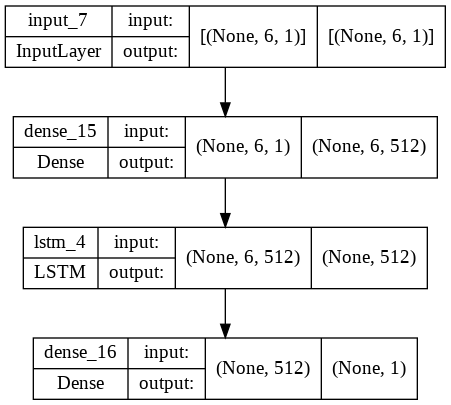

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict(train_inputs[:4])

array([[-0.00275392],
       [-0.00363952],
       [-0.00422895],
       [-0.00410025]], dtype=float32)

In [ ]:
model.predict(test_inputs[:4])

array([[-0.03115731],
       [-0.03025314],
       [-0.02865484],
       [-0.03054936]], dtype=float32)

## Train

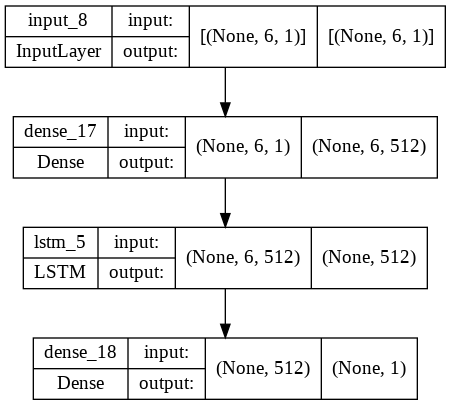

In [ ]:
set_seed(args.seed)
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="mse", optimizer="adam")

In [ ]:
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(passenger_dir, "rnn.hdf5"),
                                                  monitor='val_loss',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="min",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(passenger_dir, "rnn.csv"))

In [ ]:
history = model.fit(train_inputs, train_labels,
                    epochs=250,
                    batch_size=8,
                    validation_data=(test_inputs, test_labels),
                    callbacks=[save_weights, csv_logger])

Epoch 1/250
13/15 [=========================>....] - ETA: 0s - loss: 0.0410
Epoch 1: val_loss improved from inf to 0.01968, saving model to /content/drive/MyDrive/문서/강의계획서/삼성전기/삼성전기.20220228/data/passenger/rnn.hdf5
15/15 [==============================] - 3s 53ms/step - loss: 0.0377 - val_loss: 0.0197
Epoch 2/250
13/15 [=========================>....] - ETA: 0s - loss: 0.0066
Epoch 2: val_loss did not improve from 0.01968
15/15 [==============================] - 0s 12ms/step - loss: 0.0068 - val_loss: 0.0333
Epoch 3/250
13/15 [=========================>....] - ETA: 0s - loss: 0.0053
Epoch 3: val_loss improved from 0.01968 to 0.01390, saving model to /content/drive/MyDrive/문서/강의계획서/삼성전기/삼성전기.20220228/data/passenger/rnn.hdf5
15/15 [==============================] - 0s 15ms/step - loss: 0.0062 - val_loss: 0.0139
Epoch 4/250
12/15 [=======================>......] - ETA: 0s - loss: 0.0070
Epoch 4: val_loss improved from 0.01390 to 0.01143, sav

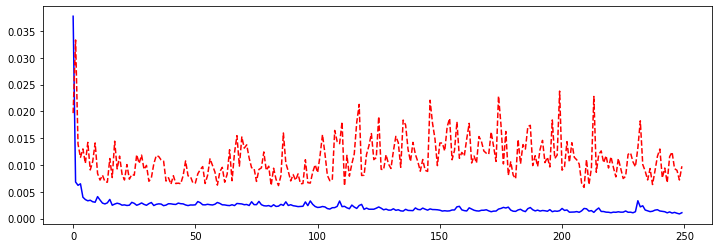

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 1, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.show()

## 평가

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(passenger_dir, "rnn.hdf5"))

In [ ]:
model.compile(loss="mse", optimizer="adam")

In [ ]:
model.evaluate(test_inputs, test_labels)

1/1 [==============================] - 1s 537ms/step - loss: 0.0058


0.005832891911268234

In [ ]:
# train 예측
train_preds = model.predict(train_inputs)
train_preds = train_preds.squeeze()
train_preds

array([ 5.35617843e-02,  7.81227201e-02,  7.85118639e-02,  5.17986566e-02,
        2.33894158e-02, -1.25005841e-04,  3.36652510e-02,  1.23636872e-02,
        3.54484729e-02,  5.33046797e-02,  4.50923033e-02,  2.90826131e-02,
        8.78697187e-02,  1.22656524e-01,  1.27344474e-01,  9.81737375e-02,
        5.03142439e-02,  2.88691688e-02,  8.91574547e-02,  7.54592791e-02,
        8.98431242e-02,  1.38009533e-01,  1.06516965e-01,  1.46899611e-01,
        1.42155543e-01,  2.12366432e-01,  1.93648890e-01,  1.62621304e-01,
        1.06581733e-01,  9.47314799e-02,  1.44036517e-01,  1.34643286e-01,
        1.62487969e-01,  1.79368973e-01,  1.55235186e-01,  1.67568848e-01,
        2.49607921e-01,  2.73906559e-01,  3.02101284e-01,  1.75465107e-01,
        1.48627669e-01,  1.50490046e-01,  2.07480535e-01,  1.91107124e-01,
        2.11067453e-01,  2.93497056e-01,  2.68196672e-01,  2.59894013e-01,
        2.78788090e-01,  3.40137333e-01,  3.77440810e-01,  2.52978623e-01,
        1.90687820e-01,  

In [ ]:
scale_labels = scaler_dic['Passengers'].inv_scale_value(train_labels)
scale_labels

array([148., 148., 136., 119., 104., 118., 115., 126., 141., 135., 125.,
       149., 170., 170., 158., 133., 114., 140., 145., 150., 178., 163.,
       172., 178., 199., 199., 184., 162., 146., 166., 171., 180., 193.,
       181., 183., 218., 230., 242., 209., 191., 172., 194., 196., 196.,
       236., 235., 229., 243., 264., 272., 237., 211., 180., 201., 204.,
       188., 235., 227., 234., 264., 302., 293., 259., 229., 203., 229.,
       242., 233., 267., 269., 270., 315., 364., 347., 312., 274., 237.,
       278., 284., 277., 317., 313., 318., 374., 413., 405., 355., 306.,
       271., 306., 315., 301., 356., 348., 355., 422., 465., 467., 404.,
       347., 305., 336., 340., 318., 362., 348., 363., 435., 491., 505.,
       404., 359., 310., 337.])

In [ ]:
scale_preds = scaler_dic['Passengers'].inv_scale_value(train_preds)
scale_preds

array([131.74501 , 144.46756 , 144.66914 , 130.8317  , 116.115715,
       103.93525 , 121.4386  , 110.40439 , 122.362305, 131.61182 ,
       127.35781 , 119.0648  , 149.51651 , 167.53607 , 169.96445 ,
       154.854   , 130.06277 , 118.95423 , 150.18356 , 143.0879  ,
       150.53874 , 175.48894 , 159.17578 , 180.094   , 177.63657 ,
       214.00581 , 204.31012 , 188.23784 , 159.20934 , 153.0709  ,
       178.61092 , 173.74522 , 188.16876 , 196.91313 , 184.41183 ,
       190.80066 , 233.2969  , 245.88359 , 260.48846 , 194.89093 ,
       180.98914 , 181.95384 , 211.47491 , 202.9935  , 213.33295 ,
       256.0315  , 242.92587 , 238.62509 , 248.41223 , 280.19113 ,
       299.51434 , 235.04292 , 202.77629 , 202.33846 , 217.07602 ,
       208.5286  , 211.82358 , 258.28854 , 230.83218 , 257.335   ,
       276.26297 , 326.56042 , 290.36923 , 238.31053 , 213.7685  ,
       233.10797 , 242.00925 , 246.24823 , 273.16724 , 291.90405 ,
       272.76196 , 292.37683 , 343.41144 , 395.30576 , 339.895

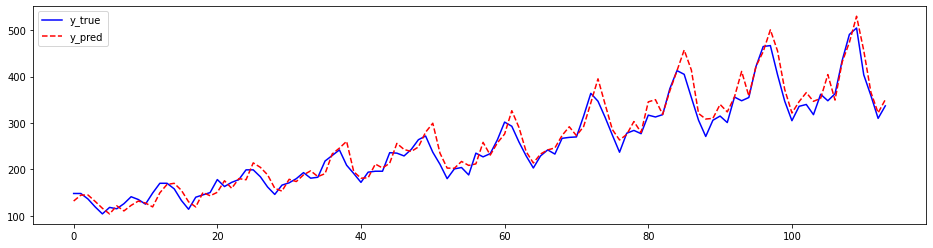

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(scale_labels, 'b-', label='y_true')
plt.plot(scale_preds, 'r--', label='y_pred')
plt.legend()
plt.show()

In [ ]:
rmse = tf.sqrt(tf.keras.losses.MSE(scale_labels, scale_preds))
rmse

<tf.Tensor: shape=(), dtype=float32, numpy=22.675842>

In [ ]:
# test 예측
test_preds = model.predict(test_inputs)
test_preds = test_preds.squeeze()
test_preds

array([0.52013797, 0.5023462 , 0.5093395 , 0.70473826, 0.56833744,
       0.73010343, 0.7160795 , 0.8907955 , 0.71821856, 0.5908881 ,
       0.519222  , 0.5167337 , 0.5792631 , 0.5486387 , 0.58605224,
       0.63865376, 0.688361  , 0.75710505, 0.8268847 , 0.8707777 ,
       0.710646  , 0.6456787 , 0.64478064, 0.4917443 ], dtype=float32)

In [ ]:
scale_labels = scaler_dic['Passengers'].inv_scale_value(test_labels)
scale_labels

array([360., 342., 406., 396., 420., 472., 548., 559., 463., 407., 362.,
       405., 417., 391., 419., 461., 472., 535., 622., 606., 508., 461.,
       390., 432.])

In [ ]:
scale_preds = scaler_dic['Passengers'].inv_scale_value(test_preds)
scale_preds

array([373.43146, 364.21533, 367.83786, 469.0544 , 398.3988 , 482.19357,
       474.92917, 565.4321 , 476.03723, 410.08002, 372.957  , 371.66806,
       404.0583 , 388.19485, 407.57507, 434.82263, 460.57098, 496.18042,
       532.3263 , 555.06287, 472.11462, 438.46158, 437.99637, 358.72357],
      dtype=float32)

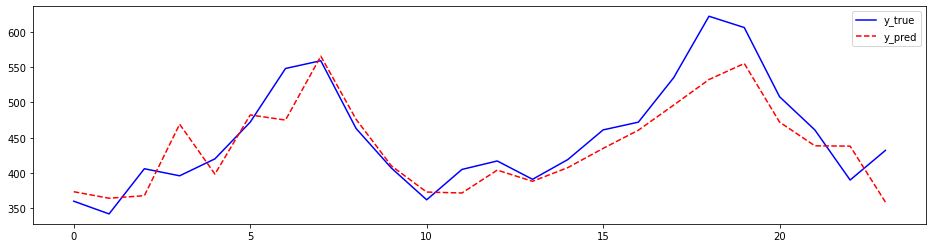

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(scale_labels, 'b-', label='y_true')
plt.plot(scale_preds, 'r--', label='y_pred')
plt.legend()
plt.show()

In [ ]:
rmse = tf.sqrt(tf.keras.losses.MSE(scale_labels, scale_preds))
rmse

<tf.Tensor: shape=(), dtype=float32, numpy=39.5614>

# RNN feature 2 (sacle)
- 입력을 min, max scaling 후 
- 이전 12개의 Passengers를 보고 RNN을 이용해 다음 Passengers 값을 예측
- 입력에 월 정보를 추가

## Config

In [ ]:
args.n_win = 6  # 이전 데이터 수 (입력 수)
args.d_rnn = 512
args.n_out = 1
args

Namespace(d_linear=256, d_rnn=512, n_out=1, n_win=6, seed=1234)

## Month Feature

In [ ]:
df_all['_Month'] = df_all.index.month
df_all

,Passengers,move_avg,move_std,move_dif,Year,_Month,Quater,Passengers_scale
Month,,,,,,,,
1949-01-01,112,NaN,NaN,NaN,1949,1,1,0.015444
1949-02-01,118,NaN,NaN,NaN,1949,2,1,0.027027
1949-03-01,132,NaN,NaN,NaN,1949,3,1,0.054054
1949-04-01,129,NaN,NaN,NaN,1949,4,2,0.048263
1949-05-01,121,NaN,NaN,NaN,1949,5,2,0.032819
...,...,...,...,...,...,...,...,...
1960-08-01,606,463.333333,83.630500,142.666667,1960,8,3,0.969112
1960-09-01,508,467.083333,84.617276,40.916667,1960,9,3,0.779923
1960-10-01,461,471.583333,82.541954,-10.583333,1960,10,4,0.689189


## Min Max Scaling

In [ ]:
class MinMaxScaler():
    def __init__(self, min_val, max_val):
        assert (max_val > min_val)
        self.min_val = min_val
        self.max_val = max_val

    def scale_value(self, val):
        return (val - self.min_val) / (self.max_val - self.min_val)

    def inv_scale_value(self, scaled_val):
        return self.min_val + scaled_val * (self.max_val - self.min_val)

In [ ]:
min_val = df_all['Passengers'].min()
max_val = df_all['Passengers'].max()
min_val, max_val

(104, 622)

In [ ]:
scaler_dic = {}
scaler_dic['Passengers'] = MinMaxScaler(min_val, max_val)

df_all['Passengers_scale'] = scaler_dic['Passengers'].scale_value(df_all['Passengers'])
df_all

,Passengers,move_avg,move_std,move_dif,Year,_Month,Quater,Passengers_scale
Month,,,,,,,,
1949-01-01,112,NaN,NaN,NaN,1949,1,1,0.015444
1949-02-01,118,NaN,NaN,NaN,1949,2,1,0.027027
1949-03-01,132,NaN,NaN,NaN,1949,3,1,0.054054
1949-04-01,129,NaN,NaN,NaN,1949,4,2,0.048263
1949-05-01,121,NaN,NaN,NaN,1949,5,2,0.032819
...,...,...,...,...,...,...,...,...
1960-08-01,606,463.333333,83.630500,142.666667,1960,8,3,0.969112
1960-09-01,508,467.083333,84.617276,40.916667,1960,9,3,0.779923
1960-10-01,461,471.583333,82.541954,-10.583333,1960,10,4,0.689189


In [ ]:
min_val = df_all['_Month'].min()
max_val = df_all['_Month'].max()
min_val, max_val

(1, 12)

In [ ]:
scaler_dic['Month'] = MinMaxScaler(min_val, max_val)

df_all['Month_scale'] = scaler_dic['Month'].scale_value(df_all['_Month'])
df_all

,Passengers,move_avg,move_std,move_dif,Year,_Month,Quater,Passengers_scale,Month_scale
Month,,,,,,,,,
1949-01-01,112,NaN,NaN,NaN,1949,1,1,0.015444,0.000000
1949-02-01,118,NaN,NaN,NaN,1949,2,1,0.027027,0.090909
1949-03-01,132,NaN,NaN,NaN,1949,3,1,0.054054,0.181818
1949-04-01,129,NaN,NaN,NaN,1949,4,2,0.048263,0.272727
1949-05-01,121,NaN,NaN,NaN,1949,5,2,0.032819,0.363636
...,...,...,...,...,...,...,...,...,...
1960-08-01,606,463.333333,83.630500,142.666667,1960,8,3,0.969112,0.636364
1960-09-01,508,467.083333,84.617276,40.916667,1960,9,3,0.779923,0.727273
1960-10-01,461,471.583333,82.541954,-10.583333,1960,10,4,0.689189,0.818182


## Train & Test Data 생성

In [ ]:
# ~ 1958 까지 Train / 이후는 Test
index = len(df_all[:'1958'])
index

120

In [ ]:
inputs = []
labels = []
n_win = 5

for i in range(0, 10):
    x = df_all.iloc[i:i + n_win][['Passengers_scale', 'Month_scale']].to_numpy().astype(float)
    y = df_all.iloc[i + n_win]['Passengers_scale']
    inputs.append(x)
    labels.append(y)
inputs = np.array(inputs)
labels = np.array(labels)

inputs.shape, labels

((10, 5, 2), array([0.05984556, 0.08494208, 0.08494208, 0.06177606, 0.02895753,
        0.        , 0.02702703, 0.02123552, 0.04247104, 0.07142857]))

In [ ]:
# 데이터 생성
def make_data(df, start, end, n_win=12):
    inputs = []
    labels = []
    #########################
    for i in range(start, end):
        x = df.iloc[i:i + n_win][['Passengers_scale', 'Month_scale']].to_numpy()
        y = df.iloc[i + n_win]['Passengers_scale']
        inputs.append(x)
        labels.append(y)
    #########################
    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

In [ ]:
# train data 생성
train_inputs, train_labels = make_data(df_all, 0, index - args.n_win, n_win=args.n_win)
train_inputs.shape, train_labels.shape

((114, 6, 2), (114,))

In [ ]:
# test data 생성
test_inputs, test_labels = make_data(df_all, index - args.n_win, len(df_all) - args.n_win, n_win=args.n_win)
test_inputs.shape, test_labels.shape

((24, 6, 2), (24,))

## Modeling

In [ ]:
def build_model(args):
    inputs = tf.keras.layers.Input((args.n_win, 2))

    dens_1 = tf.keras.layers.Dense(args.d_rnn)
    hidden = dens_1(inputs)
    
    lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(args.d_rnn))
    hidden = lstm_1(hidden)

    dens_o = tf.keras.layers.Dense(args.n_out)
    y_pred = dens_o(hidden)

    model = tf.keras.Model(inputs=inputs, outputs=y_pred)
    return model

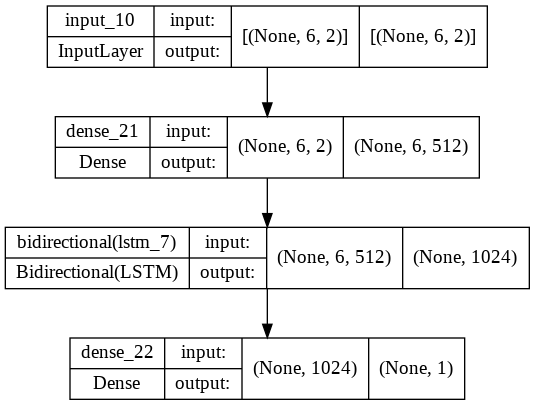

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict(train_inputs[:4])

array([[0.01015747],
       [0.01527062],
       [0.02035356],
       [0.02577546]], dtype=float32)

In [ ]:
model.predict(test_inputs[:4])

array([[0.02089777],
       [0.02057966],
       [0.02136461],
       [0.01901067]], dtype=float32)

## Train

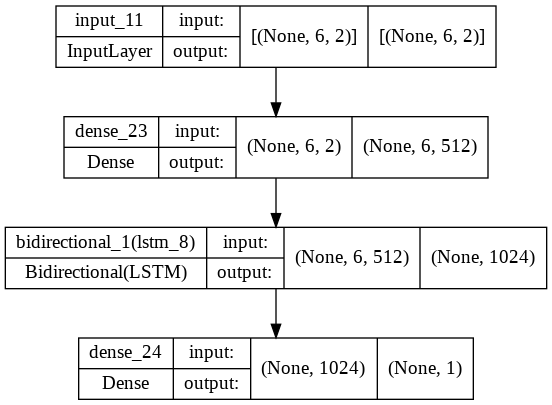

In [ ]:
set_seed(args.seed)
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="mse", optimizer="adam")

In [ ]:
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(passenger_dir, "rnn.hdf5"),
                                                  monitor='val_loss',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="min",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(passenger_dir, "rnn.csv"))

In [ ]:
history = model.fit(train_inputs, train_labels,
                    epochs=250,
                    batch_size=8,
                    validation_data=(test_inputs, test_labels),
                    callbacks=[save_weights, csv_logger])

Epoch 1/250
15/15 [==============================] - ETA: 0s - loss: 0.0406
Epoch 1: val_loss improved from inf to 0.02829, saving model to /content/drive/MyDrive/문서/강의계획서/삼성전기/삼성전기.20220228/data/passenger/rnn.hdf5
15/15 [==============================] - 5s 89ms/step - loss: 0.0406 - val_loss: 0.0283
Epoch 2/250
13/15 [=========================>....] - ETA: 0s - loss: 0.0088
Epoch 2: val_loss improved from 0.02829 to 0.01323, saving model to /content/drive/MyDrive/문서/강의계획서/삼성전기/삼성전기.20220228/data/passenger/rnn.hdf5
15/15 [==============================] - 0s 25ms/step - loss: 0.0084 - val_loss: 0.0132
Epoch 3/250
12/15 [=======================>......] - ETA: 0s - loss: 0.0036
Epoch 3: val_loss improved from 0.01323 to 0.01163, saving model to /content/drive/MyDrive/문서/강의계획서/삼성전기/삼성전기.20220228/data/passenger/rnn.hdf5
15/15 [==============================] - 0s 25ms/step - loss: 0.0041 - val_loss: 0.0116
Epoch 4/250

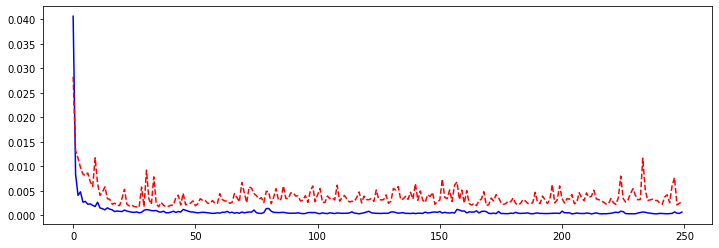

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 1, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.show()

## 평가

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(passenger_dir, "rnn.hdf5"))

In [ ]:
model.compile(loss="mse", optimizer="adam")

In [ ]:
model.evaluate(test_inputs, test_labels)

1/1 [==============================] - 1s 983ms/step - loss: 0.0016


0.0016425332287326455

In [ ]:
# train 예측
train_preds = model.predict(train_inputs)
train_preds = train_preds.squeeze()
train_preds

array([0.0973685 , 0.08655857, 0.07036836, 0.03995102, 0.01592208,
       0.01545743, 0.04227799, 0.04708598, 0.08917515, 0.07491599,
       0.06298926, 0.0873837 , 0.1206705 , 0.11988383, 0.09871716,
       0.06360406, 0.03114325, 0.03596466, 0.08078334, 0.09145197,
       0.13259254, 0.12819281, 0.10542127, 0.17472793, 0.18414782,
       0.17876214, 0.16091451, 0.11576716, 0.09366173, 0.08732191,
       0.12456165, 0.13081205, 0.19063859, 0.16805902, 0.15363345,
       0.21882738, 0.26759523, 0.23679757, 0.21838498, 0.14830062,
       0.13272804, 0.14083603, 0.17479496, 0.17716433, 0.2305413 ,
       0.24524097, 0.24196608, 0.30282813, 0.32115233, 0.30495495,
       0.29310286, 0.21804409, 0.18253359, 0.16721462, 0.20675382,
       0.20518872, 0.24305226, 0.25928742, 0.23937072, 0.31732088,
       0.35321015, 0.3449859 , 0.30428338, 0.23090954, 0.20592764,
       0.20793928, 0.25739568, 0.25244632, 0.3126186 , 0.30809563,
       0.31183875, 0.4019102 , 0.46709198, 0.4644239 , 0.38696

In [ ]:
scale_labels = scaler_dic['Passengers'].inv_scale_value(train_labels)
scale_labels

array([148., 148., 136., 119., 104., 118., 115., 126., 141., 135., 125.,
       149., 170., 170., 158., 133., 114., 140., 145., 150., 178., 163.,
       172., 178., 199., 199., 184., 162., 146., 166., 171., 180., 193.,
       181., 183., 218., 230., 242., 209., 191., 172., 194., 196., 196.,
       236., 235., 229., 243., 264., 272., 237., 211., 180., 201., 204.,
       188., 235., 227., 234., 264., 302., 293., 259., 229., 203., 229.,
       242., 233., 267., 269., 270., 315., 364., 347., 312., 274., 237.,
       278., 284., 277., 317., 313., 318., 374., 413., 405., 355., 306.,
       271., 306., 315., 301., 356., 348., 355., 422., 465., 467., 404.,
       347., 305., 336., 340., 318., 362., 348., 363., 435., 491., 505.,
       404., 359., 310., 337.])

In [ ]:
scale_preds = scaler_dic['Passengers'].inv_scale_value(train_preds)
scale_preds

array([154.43689 , 148.83734 , 140.4508  , 124.694626, 112.247635,
       112.00694 , 125.899994, 128.39053 , 150.19272 , 142.80649 ,
       136.62845 , 149.26476 , 166.50732 , 166.09982 , 155.1355  ,
       136.9469  , 120.1322  , 122.62969 , 145.84576 , 151.37213 ,
       172.68294 , 170.40387 , 158.60822 , 194.50906 , 199.38858 ,
       196.59879 , 187.35371 , 163.96739 , 152.51678 , 149.23274 ,
       168.52293 , 171.76065 , 202.7508  , 191.05457 , 183.58212 ,
       217.35258 , 242.61433 , 226.66113 , 217.12341 , 180.81972 ,
       172.75313 , 176.95306 , 194.5438  , 195.77112 , 223.4204  ,
       231.03482 , 229.33844 , 260.865   , 270.3569  , 261.96667 ,
       255.82729 , 216.94684 , 198.5524  , 190.61717 , 211.09848 ,
       210.28775 , 229.90106 , 238.31088 , 227.99403 , 268.37222 ,
       286.96286 , 282.7027  , 261.61877 , 223.61115 , 210.67052 ,
       211.71255 , 237.33096 , 234.7672  , 265.93646 , 263.59354 ,
       265.53247 , 312.18948 , 345.95364 , 344.5716  , 304.449

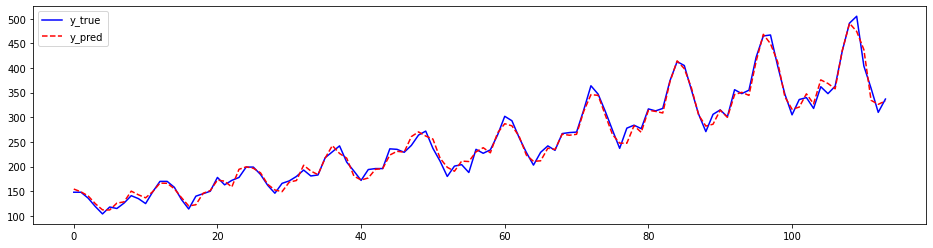

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(scale_labels, 'b-', label='y_true')
plt.plot(scale_preds, 'r--', label='y_pred')
plt.legend()
plt.show()

In [ ]:
rmse = tf.sqrt(tf.keras.losses.MSE(scale_labels, scale_preds))
rmse

<tf.Tensor: shape=(), dtype=float32, numpy=10.722855>

In [ ]:
# test 예측
test_preds = model.predict(test_inputs)
test_preds = test_preds.squeeze()
test_preds

array([0.49068618, 0.47172844, 0.55888003, 0.5744212 , 0.55270004,
       0.7304997 , 0.8199402 , 0.83046496, 0.7508102 , 0.5437191 ,
       0.51133406, 0.5218987 , 0.58957833, 0.54440844, 0.6588595 ,
       0.61577785, 0.6969951 , 0.8685474 , 0.95828307, 0.97529995,
       0.82676166, 0.6380001 , 0.6198345 , 0.5943096 ], dtype=float32)

In [ ]:
scale_labels = scaler_dic['Passengers'].inv_scale_value(test_labels)
scale_labels

array([360., 342., 406., 396., 420., 472., 548., 559., 463., 407., 362.,
       405., 417., 391., 419., 461., 472., 535., 622., 606., 508., 461.,
       390., 432.])

In [ ]:
scale_preds = scaler_dic['Passengers'].inv_scale_value(test_preds)
scale_preds

array([358.17545, 348.35535, 393.49985, 401.5502 , 390.2986 , 482.39883,
       528.729  , 534.18085, 492.91968, 385.6465 , 368.87103, 374.3435 ,
       409.40158, 386.00357, 445.2892 , 422.97293, 465.04346, 553.90753,
       600.3906 , 609.2054 , 532.2626 , 434.48404, 425.07425, 411.8524 ],
      dtype=float32)

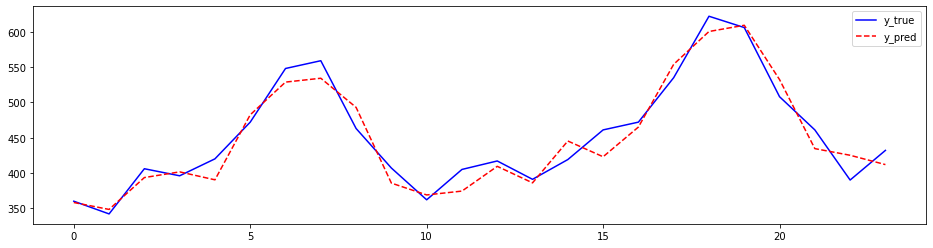

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(scale_labels, 'b-', label='y_true')
plt.plot(scale_preds, 'r--', label='y_pred')
plt.legend()
plt.show()

In [ ]:
rmse = tf.sqrt(tf.keras.losses.MSE(scale_labels, scale_preds))
rmse

<tf.Tensor: shape=(), dtype=float32, numpy=20.993595>

# RNN feature 2 (sacle, embedding)
- 입력을 min, max scaling 후 
- 이전 12개의 Passengers를 보고 RNN을 이용해 다음 Passengers 값을 예측
- 입력에 월 정보를 추가 (embedding 사용)

## Config

In [ ]:
args.n_win = 6  # 이전 데이터 수 (입력 수)
args.d_rnn = 512
args.n_out = 1
args

Namespace(d_linear=256, d_rnn=512, n_out=1, n_win=6, seed=1234)

## Month Feature

In [ ]:
df_all['_Month'] = df_all.index.month
df_all

,Passengers,move_avg,move_std,move_dif,Year,_Month,Quater,Passengers_scale,Month_scale
Month,,,,,,,,,
1949-01-01,112,NaN,NaN,NaN,1949,1,1,0.015444,0.000000
1949-02-01,118,NaN,NaN,NaN,1949,2,1,0.027027,0.090909
1949-03-01,132,NaN,NaN,NaN,1949,3,1,0.054054,0.181818
1949-04-01,129,NaN,NaN,NaN,1949,4,2,0.048263,0.272727
1949-05-01,121,NaN,NaN,NaN,1949,5,2,0.032819,0.363636
...,...,...,...,...,...,...,...,...,...
1960-08-01,606,463.333333,83.630500,142.666667,1960,8,3,0.969112,0.636364
1960-09-01,508,467.083333,84.617276,40.916667,1960,9,3,0.779923,0.727273
1960-10-01,461,471.583333,82.541954,-10.583333,1960,10,4,0.689189,0.818182


## Min Max Scaling

In [ ]:
class MinMaxScaler():
    def __init__(self, min_val, max_val):
        assert (max_val > min_val)
        self.min_val = min_val
        self.max_val = max_val

    def scale_value(self, val):
        return (val - self.min_val) / (self.max_val - self.min_val)

    def inv_scale_value(self, scaled_val):
        return self.min_val + scaled_val * (self.max_val - self.min_val)

In [ ]:
min_val = df_all['Passengers'].min()
max_val = df_all['Passengers'].max()
min_val, max_val

(104, 622)

In [ ]:
scaler_dic = {}
scaler_dic['Passengers'] = MinMaxScaler(min_val, max_val)

df_all['Passengers_scale'] = scaler_dic['Passengers'].scale_value(df_all['Passengers'])
df_all

,Passengers,move_avg,move_std,move_dif,Year,_Month,Quater,Passengers_scale,Month_scale
Month,,,,,,,,,
1949-01-01,112,NaN,NaN,NaN,1949,1,1,0.015444,0.000000
1949-02-01,118,NaN,NaN,NaN,1949,2,1,0.027027,0.090909
1949-03-01,132,NaN,NaN,NaN,1949,3,1,0.054054,0.181818
1949-04-01,129,NaN,NaN,NaN,1949,4,2,0.048263,0.272727
1949-05-01,121,NaN,NaN,NaN,1949,5,2,0.032819,0.363636
...,...,...,...,...,...,...,...,...,...
1960-08-01,606,463.333333,83.630500,142.666667,1960,8,3,0.969112,0.636364
1960-09-01,508,467.083333,84.617276,40.916667,1960,9,3,0.779923,0.727273
1960-10-01,461,471.583333,82.541954,-10.583333,1960,10,4,0.689189,0.818182


## Train & Test Data 생성

In [ ]:
# ~ 1958 까지 Train / 이후는 Test
index = len(df_all[:'1958'])
index

120

In [ ]:
inputs = []
months = []
labels = []
n_win = 5

for i in range(0, 10):
    x = df_all.iloc[i:i + n_win][['Passengers_scale']].to_numpy().astype(float)
    m = df_all.iloc[i:i + n_win]['_Month'].to_numpy().astype(int) - 1
    y = df_all.iloc[i + n_win]['Passengers_scale']
    inputs.append(x)
    months.append(m)
    labels.append(y)
inputs = np.array(inputs)
months = np.array(months)
labels = np.array(labels)

inputs.shape, months.shape, labels

((10, 5, 1),
 (10, 5),
 array([0.05984556, 0.08494208, 0.08494208, 0.06177606, 0.02895753,
        0.        , 0.02702703, 0.02123552, 0.04247104, 0.07142857]))

In [ ]:
months

array([[ 0,  1,  2,  3,  4],
       [ 1,  2,  3,  4,  5],
       [ 2,  3,  4,  5,  6],
       [ 3,  4,  5,  6,  7],
       [ 4,  5,  6,  7,  8],
       [ 5,  6,  7,  8,  9],
       [ 6,  7,  8,  9, 10],
       [ 7,  8,  9, 10, 11],
       [ 8,  9, 10, 11,  0],
       [ 9, 10, 11,  0,  1]])

In [ ]:
# 데이터 생성
def make_data(df, start, end, n_win=12):
    inputs = []
    months = []
    labels = []
    #########################
    for i in range(start, end):
        x = df.iloc[i:i + n_win][['Passengers_scale']].to_numpy()
        m = df_all.iloc[i:i + n_win]['_Month'].to_numpy().astype(int) - 1
        y = df.iloc[i + n_win]['Passengers_scale']
        inputs.append(x)
        months.append(m)
        labels.append(y)
    #########################
    inputs = np.array(inputs)
    months = np.array(months)
    labels = np.array(labels)
    return inputs, months, labels

In [ ]:
# train data 생성
train_inputs, train_months, train_labels = make_data(df_all, 0, index - args.n_win, n_win=args.n_win)
train_inputs.shape, train_months.shape, train_labels.shape

((114, 6, 1), (114, 6), (114,))

In [ ]:
# test data 생성
test_inputs, test_months, test_labels = make_data(df_all, index - args.n_win, len(df_all) - args.n_win, n_win=args.n_win)
test_inputs.shape, train_months.shape, test_labels.shape

((24, 6, 1), (114, 6), (24,))

## Modeling

In [ ]:
def build_model(args):
    inputs = tf.keras.layers.Input((args.n_win, 1))
    months = tf.keras.layers.Input((args.n_win,))

    embedding = tf.keras.layers.Embedding(12, 1)
    hidden = embedding(months)

    hidden = tf.concat([inputs, hidden], axis=-1)

    dens_1 = tf.keras.layers.Dense(args.d_rnn)
    hidden = dens_1(hidden)

    lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(args.d_rnn))
    hidden = lstm_1(hidden)

    dens_o = tf.keras.layers.Dense(args.n_out)
    y_pred = dens_o(hidden)

    model = tf.keras.Model(inputs=(inputs, months), outputs=y_pred)
    return model

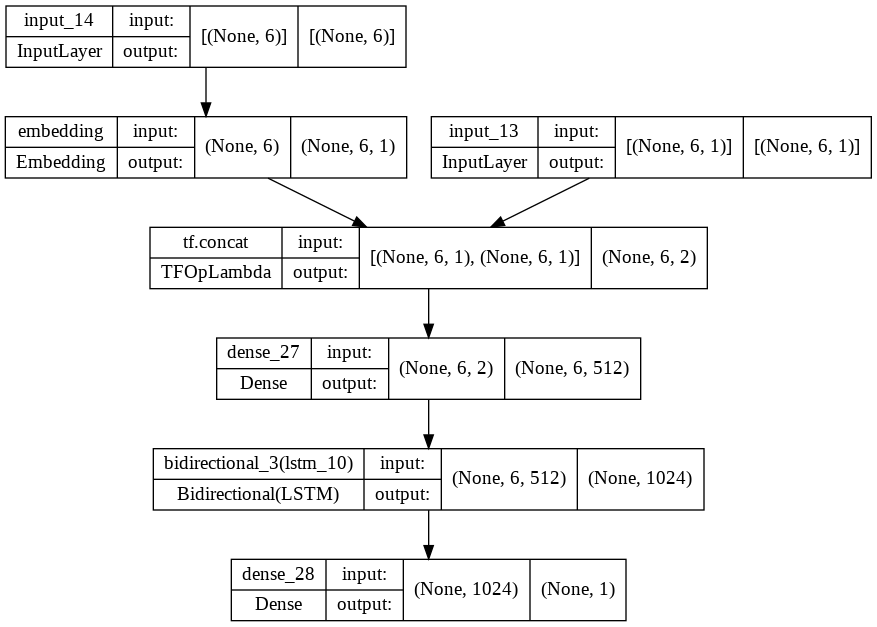

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_inputs[:4], train_months[:4]))

array([[-0.00126905],
       [-0.00204243],
       [-0.00245148],
       [-0.00237162]], dtype=float32)

In [ ]:
model.predict((test_inputs[:4], test_months[:4]))

array([[-0.02564566],
       [-0.02480436],
       [-0.02383338],
       [-0.02562653]], dtype=float32)

## Train

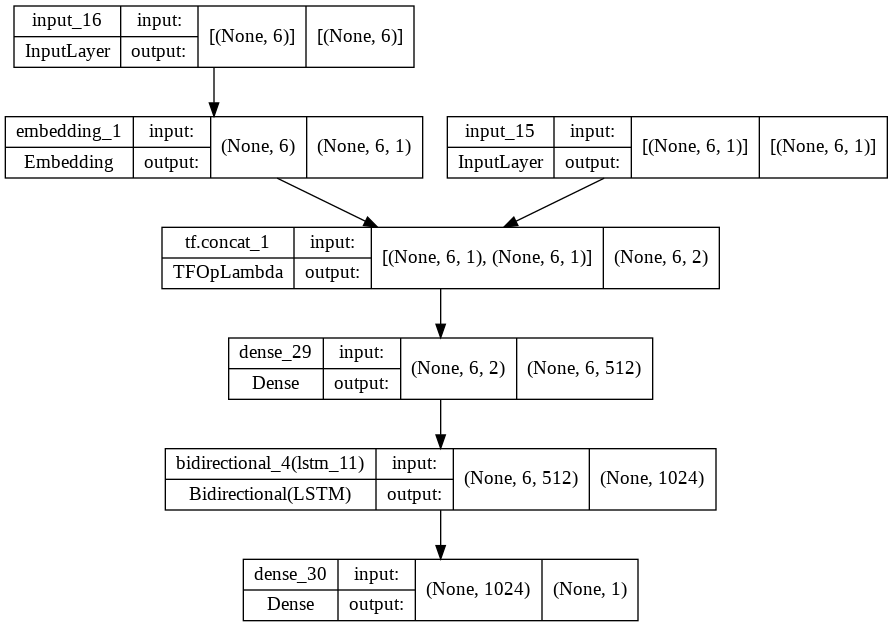

In [ ]:
set_seed(args.seed)
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="mse", optimizer="adam")

In [ ]:
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(passenger_dir, "rnn.hdf5"),
                                                  monitor='val_loss',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="min",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(passenger_dir, "rnn.csv"))

In [ ]:
history = model.fit((train_inputs, train_months), train_labels,
                    epochs=250,
                    batch_size=8,
                    validation_data=((test_inputs, test_months), test_labels),
                    callbacks=[save_weights, csv_logger])

Epoch 1/250
13/15 [=========================>....] - ETA: 0s - loss: 0.0308
Epoch 1: val_loss improved from inf to 0.06238, saving model to /content/drive/MyDrive/문서/강의계획서/삼성전기/삼성전기.20220228/data/passenger/rnn.hdf5
15/15 [==============================] - 5s 102ms/step - loss: 0.0285 - val_loss: 0.0624
Epoch 2/250
15/15 [==============================] - ETA: 0s - loss: 0.0078
Epoch 2: val_loss improved from 0.06238 to 0.01736, saving model to /content/drive/MyDrive/문서/강의계획서/삼성전기/삼성전기.20220228/data/passenger/rnn.hdf5
15/15 [==============================] - 1s 51ms/step - loss: 0.0078 - val_loss: 0.0174
Epoch 3/250
13/15 [=========================>....] - ETA: 0s - loss: 0.0042
Epoch 3: val_loss did not improve from 0.01736
15/15 [==============================] - 0s 28ms/step - loss: 0.0044 - val_loss: 0.0201
Epoch 4/250
13/15 [=========================>....] - ETA: 0s - loss: 0.0047
Epoch 4: val_loss improved from 0.01736 to 0.01417, sa

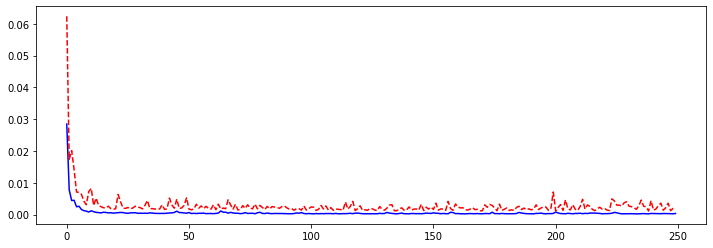

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 1, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.show()

## 평가

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(passenger_dir, "rnn.hdf5"))

In [ ]:
model.compile(loss="mse", optimizer="adam")

In [ ]:
model.evaluate((test_inputs, test_months), test_labels)

1/1 [==============================] - 1s 1s/step - loss: 0.0011


0.0011078856186941266

In [ ]:
# train 예측
train_preds = model.predict((train_inputs, train_months))
train_preds = train_preds.squeeze()
train_preds

array([ 9.39075500e-02,  8.66999328e-02,  6.51513338e-02,  3.75420675e-02,
       -3.81354243e-04,  2.78312881e-02,  3.92924100e-02,  4.01508361e-02,
        7.56614283e-02,  6.72977939e-02,  5.45639247e-02,  7.91768730e-02,
        1.15091845e-01,  1.22927517e-01,  9.77062285e-02,  6.74142540e-02,
        2.08468605e-02,  5.14740013e-02,  7.70206302e-02,  8.71890187e-02,
        1.27698585e-01,  1.22870058e-01,  1.05355911e-01,  1.64842367e-01,
        1.91923022e-01,  1.80193633e-01,  1.53522983e-01,  1.16708860e-01,
        7.92058930e-02,  1.14352196e-01,  1.29989430e-01,  1.33334398e-01,
        1.90055579e-01,  1.67659760e-01,  1.49893597e-01,  2.03073829e-01,
        2.69447893e-01,  2.52730697e-01,  2.13738233e-01,  1.62424758e-01,
        1.21346548e-01,  1.74257606e-01,  1.86341688e-01,  1.83862776e-01,
        2.33174860e-01,  2.40686744e-01,  2.51717269e-01,  3.10336441e-01,
        3.38478416e-01,  3.17013890e-01,  2.76706666e-01,  2.22536907e-01,
        1.66176975e-01,  

In [ ]:
scale_labels = scaler_dic['Passengers'].inv_scale_value(train_labels)
scale_labels

array([148., 148., 136., 119., 104., 118., 115., 126., 141., 135., 125.,
       149., 170., 170., 158., 133., 114., 140., 145., 150., 178., 163.,
       172., 178., 199., 199., 184., 162., 146., 166., 171., 180., 193.,
       181., 183., 218., 230., 242., 209., 191., 172., 194., 196., 196.,
       236., 235., 229., 243., 264., 272., 237., 211., 180., 201., 204.,
       188., 235., 227., 234., 264., 302., 293., 259., 229., 203., 229.,
       242., 233., 267., 269., 270., 315., 364., 347., 312., 274., 237.,
       278., 284., 277., 317., 313., 318., 374., 413., 405., 355., 306.,
       271., 306., 315., 301., 356., 348., 355., 422., 465., 467., 404.,
       347., 305., 336., 340., 318., 362., 348., 363., 435., 491., 505.,
       404., 359., 310., 337.])

In [ ]:
scale_preds = scaler_dic['Passengers'].inv_scale_value(train_preds)
scale_preds

array([152.6441  , 148.91057 , 137.74838 , 123.44679 , 103.80246 ,
       118.41661 , 124.35347 , 124.798134, 143.19263 , 138.86026 ,
       132.26411 , 145.01361 , 163.61758 , 167.67645 , 154.61183 ,
       138.92058 , 114.798676, 130.66353 , 143.89668 , 149.16391 ,
       170.14786 , 167.6467  , 158.57437 , 189.38834 , 203.41612 ,
       197.3403  , 183.5249  , 164.45518 , 145.02866 , 163.23444 ,
       171.33453 , 173.06721 , 202.44879 , 190.84775 , 181.64488 ,
       209.19225 , 243.574   , 234.9145  , 214.7164  , 188.13602 ,
       166.85751 , 194.26544 , 200.525   , 199.24092 , 224.78458 ,
       228.67574 , 234.38954 , 264.75427 , 279.33182 , 268.2132  ,
       247.33405 , 219.27411 , 190.07968 , 208.52472 , 212.18143 ,
       209.71597 , 226.475   , 230.92468 , 230.91951 , 268.92484 ,
       299.2403  , 302.0332  , 265.80273 , 232.67535 , 204.52972 ,
       232.87642 , 240.39996 , 239.8799  , 272.52695 , 265.3661  ,
       273.14462 , 317.64038 , 360.63474 , 373.47253 , 315.190

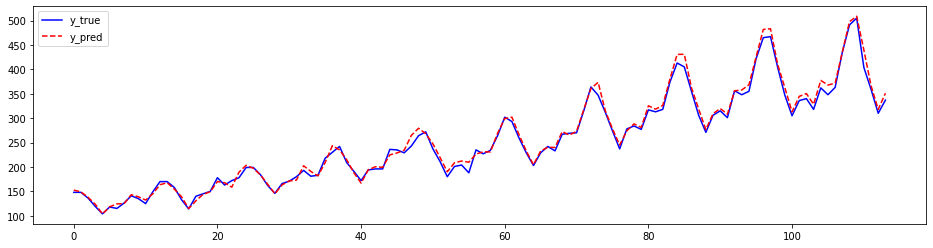

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(scale_labels, 'b-', label='y_true')
plt.plot(scale_preds, 'r--', label='y_pred')
plt.legend()
plt.show()

In [ ]:
rmse = tf.sqrt(tf.keras.losses.MSE(scale_labels, scale_preds))
rmse

<tf.Tensor: shape=(), dtype=float32, numpy=9.293331>

In [ ]:
# test 예측
test_preds = model.predict((test_inputs, test_months))
test_preds = test_preds.squeeze()
test_preds

array([0.47995877, 0.45464718, 0.5816466 , 0.5871453 , 0.6120963 ,
       0.76076317, 0.8280427 , 0.8728938 , 0.7283145 , 0.60058856,
       0.49158537, 0.57817787, 0.5994083 , 0.5463706 , 0.6802457 ,
       0.61241525, 0.7251357 , 0.8829924 , 0.93021965, 0.9877005 ,
       0.79240376, 0.6594023 , 0.5761431 , 0.6387383 ], dtype=float32)

In [ ]:
scale_labels = scaler_dic['Passengers'].inv_scale_value(test_labels)
scale_labels

array([360., 342., 406., 396., 420., 472., 548., 559., 463., 407., 362.,
       405., 417., 391., 419., 461., 472., 535., 622., 606., 508., 461.,
       390., 432.])

In [ ]:
scale_preds = scaler_dic['Passengers'].inv_scale_value(test_preds)
scale_preds

array([352.61865, 339.50726, 405.29294, 408.14127, 421.0659 , 498.07532,
       532.92615, 556.159  , 481.2669 , 415.1049 , 358.64124, 403.49612,
       414.4935 , 387.02   , 456.36728, 421.2311 , 479.62027, 561.39   ,
       585.85376, 615.6289 , 514.46515, 445.5704 , 402.4421 , 434.86642],
      dtype=float32)

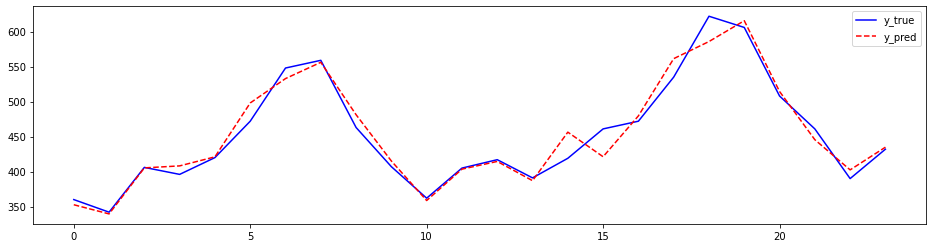

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(scale_labels, 'b-', label='y_true')
plt.plot(scale_preds, 'r--', label='y_pred')
plt.legend()
plt.show()

In [ ]:
rmse = tf.sqrt(tf.keras.losses.MSE(scale_labels, scale_preds))
rmse

<tf.Tensor: shape=(), dtype=float32, numpy=17.241585>

# RNN feature 2 (sacle, embedding) LM
- 입력을 min, max scaling 후 
- 이전 12개의 Passengers를 보고 RNN을 이용해 다음 Passengers 값을 예측
- 입력에 월 정보를 추가 (embedding 사용)
- lm 방식 추론

## Config

In [ ]:
args.n_win = 6  # 이전 데이터 수 (입력 수)
args.d_rnn = 512
args.n_out = 1
args

Namespace(d_linear=256, d_rnn=512, n_out=1, n_win=6, seed=1234)

## Month Feature

In [ ]:
df_all['_Month'] = df_all.index.month
df_all

,Passengers,move_avg,move_std,move_dif,Year,_Month,Quater,Passengers_scale,Month_scale
Month,,,,,,,,,
1949-01-01,112,NaN,NaN,NaN,1949,1,1,0.015444,0.000000
1949-02-01,118,NaN,NaN,NaN,1949,2,1,0.027027,0.090909
1949-03-01,132,NaN,NaN,NaN,1949,3,1,0.054054,0.181818
1949-04-01,129,NaN,NaN,NaN,1949,4,2,0.048263,0.272727
1949-05-01,121,NaN,NaN,NaN,1949,5,2,0.032819,0.363636
...,...,...,...,...,...,...,...,...,...
1960-08-01,606,463.333333,83.630500,142.666667,1960,8,3,0.969112,0.636364
1960-09-01,508,467.083333,84.617276,40.916667,1960,9,3,0.779923,0.727273
1960-10-01,461,471.583333,82.541954,-10.583333,1960,10,4,0.689189,0.818182


## Min Max Scaling

In [ ]:
class MinMaxScaler():
    def __init__(self, min_val, max_val):
        assert (max_val > min_val)
        self.min_val = min_val
        self.max_val = max_val

    def scale_value(self, val):
        return (val - self.min_val) / (self.max_val - self.min_val)

    def inv_scale_value(self, scaled_val):
        return self.min_val + scaled_val * (self.max_val - self.min_val)

In [ ]:
min_val = df_all['Passengers'].min()
max_val = df_all['Passengers'].max()
min_val, max_val

(104, 622)

In [ ]:
scaler_dic = {}
scaler_dic['Passengers'] = MinMaxScaler(min_val, max_val)

df_all['Passengers_scale'] = scaler_dic['Passengers'].scale_value(df_all['Passengers'])
df_all

,Passengers,move_avg,move_std,move_dif,Year,_Month,Quater,Passengers_scale,Month_scale
Month,,,,,,,,,
1949-01-01,112,NaN,NaN,NaN,1949,1,1,0.015444,0.000000
1949-02-01,118,NaN,NaN,NaN,1949,2,1,0.027027,0.090909
1949-03-01,132,NaN,NaN,NaN,1949,3,1,0.054054,0.181818
1949-04-01,129,NaN,NaN,NaN,1949,4,2,0.048263,0.272727
1949-05-01,121,NaN,NaN,NaN,1949,5,2,0.032819,0.363636
...,...,...,...,...,...,...,...,...,...
1960-08-01,606,463.333333,83.630500,142.666667,1960,8,3,0.969112,0.636364
1960-09-01,508,467.083333,84.617276,40.916667,1960,9,3,0.779923,0.727273
1960-10-01,461,471.583333,82.541954,-10.583333,1960,10,4,0.689189,0.818182


## Train & Test Data 생성

In [ ]:
# ~ 1958 까지 Train / 이후는 Test
index = len(df_all[:'1958'])
index

120

In [ ]:
inputs = []
months = []
labels = []
n_win = 5

for i in range(0, 10):
    x = df_all.iloc[i:i + n_win][['Passengers_scale']].to_numpy().astype(float)
    m = df_all.iloc[i:i + n_win]['_Month'].to_numpy().astype(int) - 1
    y = df_all.iloc[i + 1:i + n_win + 1]['Passengers_scale']
    inputs.append(x)
    months.append(m)
    labels.append(y)
inputs = np.array(inputs)
months = np.array(months)
labels = np.array(labels)

inputs.shape, months.shape, labels.shape

((10, 5, 1), (10, 5), (10, 5))

In [ ]:
months

array([[ 0,  1,  2,  3,  4],
       [ 1,  2,  3,  4,  5],
       [ 2,  3,  4,  5,  6],
       [ 3,  4,  5,  6,  7],
       [ 4,  5,  6,  7,  8],
       [ 5,  6,  7,  8,  9],
       [ 6,  7,  8,  9, 10],
       [ 7,  8,  9, 10, 11],
       [ 8,  9, 10, 11,  0],
       [ 9, 10, 11,  0,  1]])

In [ ]:
# 데이터 생성
def make_data(df, start, end, n_win=12):
    inputs = []
    months = []
    labels = []
    #########################
    for i in range(start, end):
        x = df.iloc[i:i + n_win][['Passengers_scale']].to_numpy()
        m = df_all.iloc[i:i + n_win]['_Month'].to_numpy().astype(int) - 1
        y = df_all.iloc[i + 1:i + n_win + 1]['Passengers_scale']
        inputs.append(x)
        months.append(m)
        labels.append(y)
    #########################
    inputs = np.array(inputs)
    months = np.array(months)
    labels = np.array(labels)
    return inputs, months, labels

In [ ]:
# train data 생성
train_inputs, train_months, train_labels = make_data(df_all, 0, index - args.n_win, n_win=args.n_win)
train_inputs.shape, train_months.shape, train_labels.shape

((114, 6, 1), (114, 6), (114, 6))

In [ ]:
# test data 생성
test_inputs, test_months, test_labels = make_data(df_all, index - args.n_win, len(df_all) - args.n_win, n_win=args.n_win)
test_inputs.shape, train_months.shape, test_labels.shape

((24, 6, 1), (114, 6), (24, 6))

## Modeling

In [ ]:
def build_model(args):
    inputs = tf.keras.layers.Input((args.n_win, 1))
    months = tf.keras.layers.Input((args.n_win,))

    embedding = tf.keras.layers.Embedding(12, 1)
    hidden = embedding(months)

    hidden = tf.concat([inputs, hidden], axis=-1)

    dens_1 = tf.keras.layers.Dense(args.d_rnn)
    hidden = dens_1(hidden)

    lstm_1 = tf.keras.layers.LSTM(args.d_rnn, return_sequences=True)
    hidden = lstm_1(hidden)

    dens_o = tf.keras.layers.Dense(args.n_out)
    y_pred = dens_o(hidden)
    y_pred = tf.squeeze(y_pred, axis=-1)

    model = tf.keras.Model(inputs=(inputs, months), outputs=y_pred)
    return model

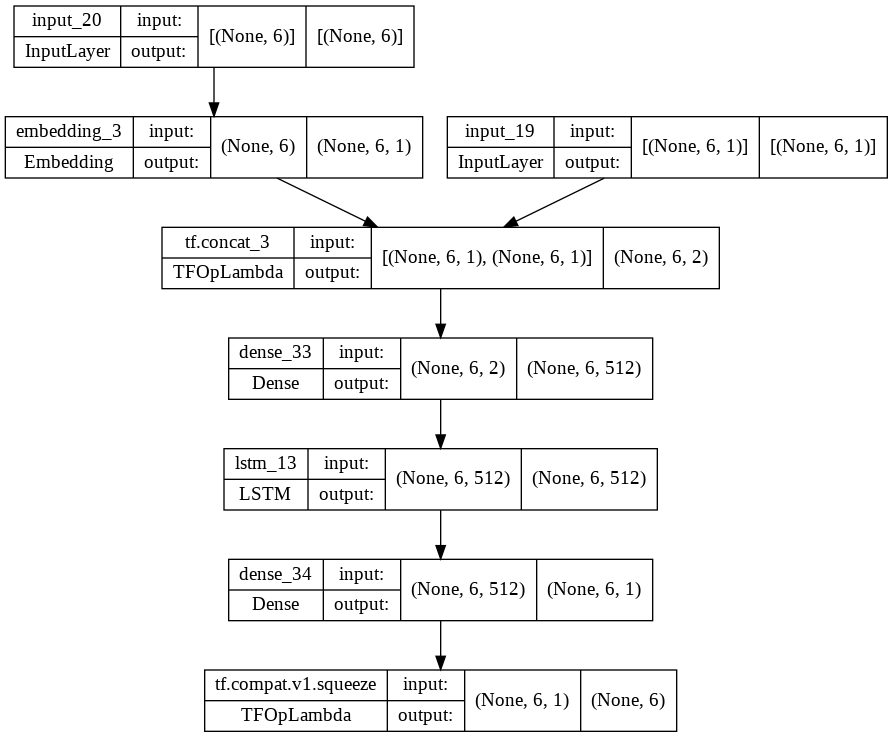

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_inputs[:4], train_months[:4]))

array([[-3.3025054e-04, -4.6369247e-04, -1.8549033e-03, -1.2498298e-03,
        -4.3707434e-05,  4.6221190e-05],
       [-2.4689944e-04, -1.7155611e-03, -1.1627672e-03,  8.1981998e-06,
         7.4618263e-05,  8.8726403e-05],
       [-1.5830116e-03, -1.0989684e-03,  3.1557516e-05,  7.4711628e-05,
         7.5977761e-05, -1.7162185e-03],
       [-2.1162414e-05,  7.5307256e-04,  5.4658786e-04,  3.7483964e-04,
        -1.5367311e-03, -2.5422140e-03]], dtype=float32)

In [ ]:
model.predict((test_inputs[:4], test_months[:4]))

array([[-0.00977229, -0.01793955, -0.02013119, -0.01998045, -0.01794058,
        -0.01621134],
       [-0.01206007, -0.01675864, -0.01821397, -0.01718372, -0.01608014,
        -0.01640552],
       [-0.00922564, -0.01367604, -0.01460064, -0.01476364, -0.01589834,
        -0.01566507],
       [-0.00789639, -0.01109638, -0.01275186, -0.01485546, -0.01524266,
        -0.01798185]], dtype=float32)

## Train

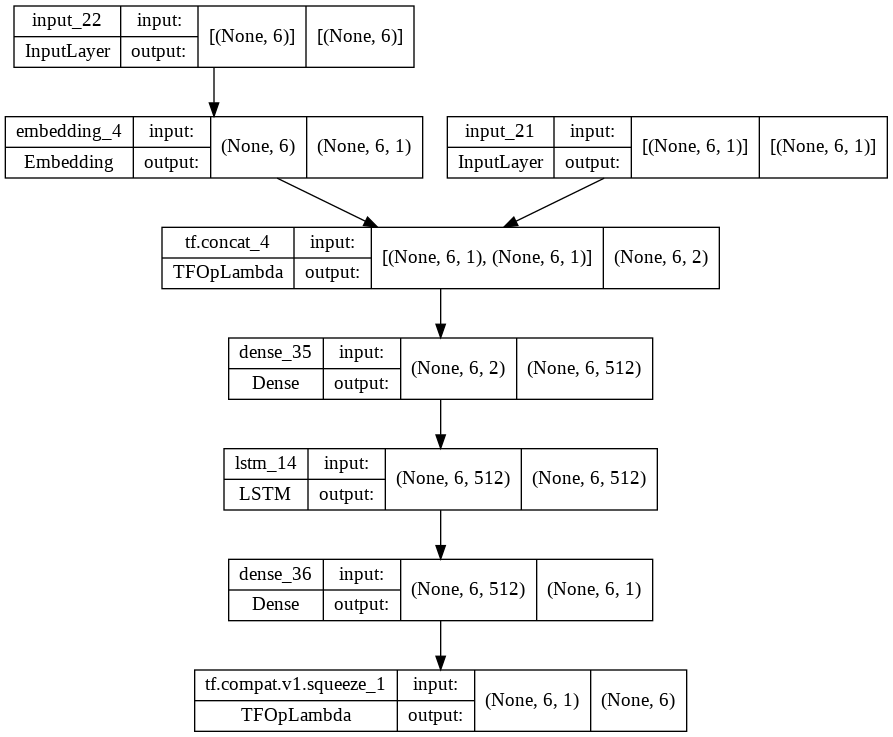

In [ ]:
set_seed(args.seed)
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="mse", optimizer="adam")

In [ ]:
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(passenger_dir, "rnn.hdf5"),
                                                  monitor='val_loss',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="min",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(passenger_dir, "rnn.csv"))

In [ ]:
history = model.fit((train_inputs, train_months), train_labels,
                    epochs=250,
                    batch_size=8,
                    validation_data=((test_inputs, test_months), test_labels),
                    callbacks=[save_weights, csv_logger])

Epoch 1/250
11/15 [=====================>........] - ETA: 0s - loss: 0.0366
Epoch 1: val_loss improved from inf to 0.02026, saving model to /content/drive/MyDrive/문서/강의계획서/삼성전기/삼성전기.20220228/data/passenger/rnn.hdf5
15/15 [==============================] - 3s 77ms/step - loss: 0.0295 - val_loss: 0.0203
Epoch 2/250
11/15 [=====================>........] - ETA: 0s - loss: 0.0058
Epoch 2: val_loss improved from 0.02026 to 0.01683, saving model to /content/drive/MyDrive/문서/강의계획서/삼성전기/삼성전기.20220228/data/passenger/rnn.hdf5
15/15 [==============================] - 0s 18ms/step - loss: 0.0053 - val_loss: 0.0168
Epoch 3/250
11/15 [=====================>........] - ETA: 0s - loss: 0.0030
Epoch 3: val_loss improved from 0.01683 to 0.00890, saving model to /content/drive/MyDrive/문서/강의계획서/삼성전기/삼성전기.20220228/data/passenger/rnn.hdf5
15/15 [==============================] - 0s 18ms/step - loss: 0.0031 - val_loss: 0.0089
Epoch 4/250

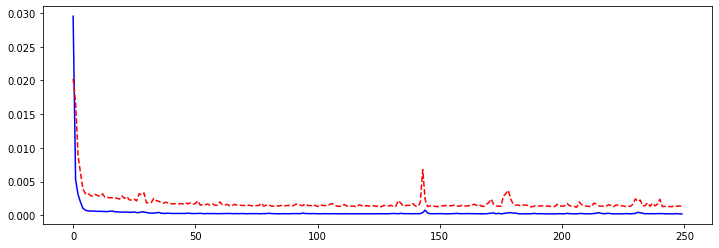

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 1, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.show()

## 평가

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(passenger_dir, "rnn.hdf5"))

In [ ]:
model.compile(loss="mse", optimizer="adam")

In [ ]:
model.evaluate((test_inputs, test_months), test_labels)

1/1 [==============================] - 1s 597ms/step - loss: 0.0012


0.0011957878014072776

In [ ]:
# train 예측
train_preds = model.predict((train_inputs, train_months))
train_preds[:, -1]

array([0.07880292, 0.0879632 , 0.07238296, 0.03851929, 0.00651602,
       0.03574211, 0.04161015, 0.03420761, 0.07973871, 0.0747489 ,
       0.06296039, 0.066716  , 0.10816458, 0.12961355, 0.1102391 ,
       0.07683901, 0.0327257 , 0.05678754, 0.08373257, 0.0884844 ,
       0.13221784, 0.14338224, 0.12012244, 0.17015103, 0.17365243,
       0.187041  , 0.16006988, 0.12287231, 0.08345447, 0.12337082,
       0.13463108, 0.13581945, 0.1976677 , 0.17358674, 0.15691243,
       0.19725458, 0.2575866 , 0.2478301 , 0.22958769, 0.16911806,
       0.13280599, 0.17759095, 0.18853171, 0.18100516, 0.23388982,
       0.2509539 , 0.26135862, 0.30304345, 0.31645638, 0.31324625,
       0.27903706, 0.21720491, 0.1690987 , 0.19509184, 0.20205002,
       0.19474544, 0.21765591, 0.24875794, 0.24690089, 0.311742  ,
       0.3593808 , 0.38298833, 0.3150428 , 0.25325903, 0.20016418,
       0.24218033, 0.25545728, 0.26119083, 0.31641507, 0.30937338,
       0.3290577 , 0.39730367, 0.47163334, 0.50192094, 0.39987

In [ ]:
scale_labels = scaler_dic['Passengers'].inv_scale_value(train_labels[:, -1])
scale_labels

array([148., 148., 136., 119., 104., 118., 115., 126., 141., 135., 125.,
       149., 170., 170., 158., 133., 114., 140., 145., 150., 178., 163.,
       172., 178., 199., 199., 184., 162., 146., 166., 171., 180., 193.,
       181., 183., 218., 230., 242., 209., 191., 172., 194., 196., 196.,
       236., 235., 229., 243., 264., 272., 237., 211., 180., 201., 204.,
       188., 235., 227., 234., 264., 302., 293., 259., 229., 203., 229.,
       242., 233., 267., 269., 270., 315., 364., 347., 312., 274., 237.,
       278., 284., 277., 317., 313., 318., 374., 413., 405., 355., 306.,
       271., 306., 315., 301., 356., 348., 355., 422., 465., 467., 404.,
       347., 305., 336., 340., 318., 362., 348., 363., 435., 491., 505.,
       404., 359., 310., 337.])

In [ ]:
scale_preds = scaler_dic['Passengers'].inv_scale_value(train_preds[:, -1])
scale_preds

array([144.81992 , 149.56494 , 141.49438 , 123.952995, 107.3753  ,
       122.51441 , 125.55406 , 121.71954 , 145.30466 , 142.71992 ,
       136.61348 , 138.55888 , 160.02925 , 171.13982 , 161.10385 ,
       143.80261 , 120.95191 , 133.41594 , 147.37347 , 149.83492 ,
       172.48883 , 178.272   , 166.22342 , 192.13823 , 193.95197 ,
       200.88724 , 186.9162  , 167.64786 , 147.22942 , 167.90608 ,
       173.73889 , 174.35448 , 206.39188 , 193.91794 , 185.28064 ,
       206.17787 , 237.42986 , 232.37599 , 222.92642 , 191.60315 ,
       172.7935  , 195.99211 , 201.65942 , 197.76068 , 225.15492 ,
       233.99413 , 239.38376 , 260.9765  , 267.9244  , 266.26154 ,
       248.5412  , 216.51215 , 191.59314 , 205.05757 , 208.66191 ,
       204.87814 , 216.74576 , 232.85661 , 231.89465 , 265.48236 ,
       290.15924 , 302.38794 , 267.19217 , 235.18819 , 207.68506 ,
       229.4494  , 236.32687 , 239.29684 , 267.903   , 264.25543 ,
       274.4519  , 309.80328 , 348.3061  , 363.99506 , 311.134

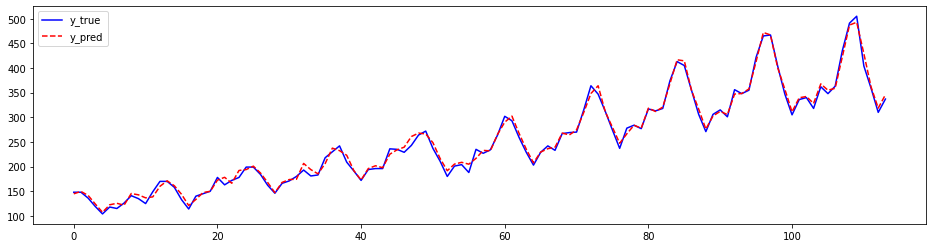

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(scale_labels, 'b-', label='y_true')
plt.plot(scale_preds, 'r--', label='y_pred')
plt.legend()
plt.show()

In [ ]:
rmse = tf.sqrt(tf.keras.losses.MSE(scale_labels, scale_preds))
rmse

<tf.Tensor: shape=(), dtype=float32, numpy=7.9752884>

In [ ]:
# test 예측
test_preds = model.predict((test_inputs, test_months))
test_preds[:, -1]

array([0.46224168, 0.46434036, 0.562856  , 0.5632159 , 0.58682805,
       0.74751025, 0.8272285 , 0.85781735, 0.7063645 , 0.5815031 ,
       0.49093175, 0.5749756 , 0.59163123, 0.5661573 , 0.6778279 ,
       0.5923992 , 0.70703393, 0.87663025, 0.9637928 , 0.99741644,
       0.7747399 , 0.641777  , 0.56782204, 0.64323354], dtype=float32)

In [ ]:
scale_labels = scaler_dic['Passengers'].inv_scale_value(test_labels[:, -1])
scale_labels

array([360., 342., 406., 396., 420., 472., 548., 559., 463., 407., 362.,
       405., 417., 391., 419., 461., 472., 535., 622., 606., 508., 461.,
       390., 432.])

In [ ]:
scale_preds = scaler_dic['Passengers'].inv_scale_value(test_preds[:, -1])
scale_preds

array([343.4412 , 344.52832, 395.55942, 395.74585, 407.97693, 491.2103 ,
       532.5044 , 548.34937, 469.89682, 405.2186 , 358.30264, 401.83737,
       410.46497, 397.26947, 455.11484, 410.86276, 470.2436 , 558.0945 ,
       603.2446 , 620.66174, 505.31528, 436.44046, 398.1318 , 437.19498],
      dtype=float32)

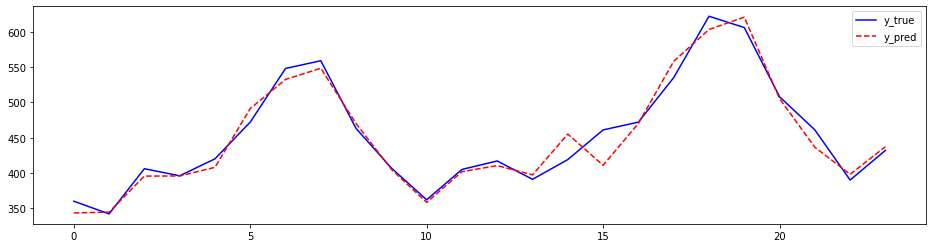

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(scale_labels, 'b-', label='y_true')
plt.plot(scale_preds, 'r--', label='y_pred')
plt.legend()
plt.show()

In [ ]:
rmse = tf.sqrt(tf.keras.losses.MSE(scale_labels, scale_preds))
rmse

<tf.Tensor: shape=(), dtype=float32, numpy=17.124434>

# RNN feature 2 (sacle, embedding) seq2seq
- 입력을 min, max scaling 후 
- 이전 12개의 Passengers를 보고 RNN을 이용해 다음 Passengers 값을 예측
- 입력에 월 정보를 추가 (embedding 사용)
- seq2seq 방식 추론

## Config

In [22]:
args.n_win = 6  # 이전 데이터 수 (입력 수)
args.d_rnn = 512
args.n_out = 1
args

Namespace(d_rnn=512, n_out=1, n_win=6, seed=1234)

## Month Feature

In [23]:
df_all['_Month'] = df_all.index.month
df_all

,Passengers,_Month
Month,,
1949-01-01,112,1
1949-02-01,118,2
1949-03-01,132,3
1949-04-01,129,4
1949-05-01,121,5
...,...,...
1960-08-01,606,8
1960-09-01,508,9
1960-10-01,461,10


## Min Max Scaling

In [24]:
class MinMaxScaler():
    def __init__(self, min_val, max_val):
        assert (max_val > min_val)
        self.min_val = min_val
        self.max_val = max_val

    def scale_value(self, val):
        return (val - self.min_val) / (self.max_val - self.min_val)

    def inv_scale_value(self, scaled_val):
        return self.min_val + scaled_val * (self.max_val - self.min_val)

In [25]:
min_val = df_all['Passengers'].min()
max_val = df_all['Passengers'].max()
min_val, max_val

(104, 622)

In [26]:
scaler_dic = {}
scaler_dic['Passengers'] = MinMaxScaler(min_val, max_val)

df_all['Passengers_scale'] = scaler_dic['Passengers'].scale_value(df_all['Passengers'])
df_all

,Passengers,_Month,Passengers_scale
Month,,,
1949-01-01,112,1,0.015444
1949-02-01,118,2,0.027027
1949-03-01,132,3,0.054054
1949-04-01,129,4,0.048263
1949-05-01,121,5,0.032819
...,...,...,...
1960-08-01,606,8,0.969112
1960-09-01,508,9,0.779923
1960-10-01,461,10,0.689189


## Train & Test Data 생성

In [27]:
# ~ 1958 까지 Train / 이후는 Test
index = len(df_all[:'1958'])
index

120

In [28]:
enc_xs = []
enc_ms = []
dec_xs = []
dec_ms = []
dec_ys = []
n_win = 5

for i in range(0, 1):
    enc_x = df_all.iloc[i:i + n_win][['Passengers_scale']].to_numpy().astype(float)
    enc_m = df_all.iloc[i:i + n_win]['_Month'].to_numpy().astype(int) - 1
    dec_i = i + n_win - 1
    dec_x = df_all.iloc[dec_i:dec_i + n_win][['Passengers_scale']]
    dec_m = df_all.iloc[dec_i:dec_i + n_win]['_Month'].to_numpy().astype(int) - 1
    dec_y = df_all.iloc[dec_i + 1:dec_i + n_win + 1]['Passengers_scale']
    enc_xs.append(enc_x)
    enc_ms.append(enc_m)
    dec_xs.append(dec_x)
    dec_ms.append(dec_m)
    dec_ys.append(dec_y)
enc_xs = np.array(enc_xs)
enc_ms = np.array(enc_ms)
dec_xs = np.array(dec_xs)
dec_ms = np.array(dec_ms)
dec_ys = np.array(dec_ys)

enc_xs, enc_ms, dec_xs, dec_ms, dec_ys

(array([[[0.01544402],
         [0.02702703],
         [0.05405405],
         [0.04826255],
         [0.03281853]]]), array([[0, 1, 2, 3, 4]]), array([[[0.03281853],
         [0.05984556],
         [0.08494208],
         [0.08494208],
         [0.06177606]]]), array([[4, 5, 6, 7, 8]]), array([[0.05984556, 0.08494208, 0.08494208, 0.06177606, 0.02895753]]))

In [29]:
# 데이터 생성
def make_data(df, start, end, n_win=12):
    enc_xs = []
    enc_ms = []
    dec_xs = []
    dec_ms = []
    dec_ys = []
    #########################
    for i in range(start, end):
        enc_x = df_all.iloc[i:i + n_win][['Passengers_scale']].to_numpy().astype(float)
        enc_m = df_all.iloc[i:i + n_win]['_Month'].to_numpy().astype(int) - 1
        dec_i = i + n_win - 1
        dec_x = df_all.iloc[dec_i:dec_i + n_win][['Passengers_scale']]
        dec_m = df_all.iloc[dec_i:dec_i + n_win]['_Month'].to_numpy().astype(int) - 1
        dec_y = df_all.iloc[dec_i + 1:dec_i + n_win + 1]['Passengers_scale']
        enc_xs.append(enc_x)
        enc_ms.append(enc_m)
        dec_xs.append(dec_x)
        dec_ms.append(dec_m)
        dec_ys.append(dec_y)
    #########################
    enc_xs = np.array(enc_xs)
    enc_ms = np.array(enc_ms)
    dec_xs = np.array(dec_xs)
    dec_ms = np.array(dec_ms)
    dec_ys = np.array(dec_ys)
    return enc_xs, enc_ms, dec_xs, dec_ms, dec_ys

In [30]:
# train data 생성
train_enc_xs, train_enc_ms, train_dec_xs, train_dec_ms, train_dec_ys = make_data(df_all, 0, index - 2 * args.n_win + 1, n_win=args.n_win)
train_enc_xs, train_enc_ms, train_dec_xs, train_dec_ms, train_dec_ys

(array([[[0.01544402],
         [0.02702703],
         [0.05405405],
         [0.04826255],
         [0.03281853],
         [0.05984556]],
 
        [[0.02702703],
         [0.05405405],
         [0.04826255],
         [0.03281853],
         [0.05984556],
         [0.08494208]],
 
        [[0.05405405],
         [0.04826255],
         [0.03281853],
         [0.05984556],
         [0.08494208],
         [0.08494208]],
 
        [[0.04826255],
         [0.03281853],
         [0.05984556],
         [0.08494208],
         [0.08494208],
         [0.06177606]],
 
        [[0.03281853],
         [0.05984556],
         [0.08494208],
         [0.08494208],
         [0.06177606],
         [0.02895753]],
 
        [[0.05984556],
         [0.08494208],
         [0.08494208],
         [0.06177606],
         [0.02895753],
         [0.        ]],
 
        [[0.08494208],
         [0.08494208],
         [0.06177606],
         [0.02895753],
         [0.        ],
         [0.02702703]],
 
        [[0.0

In [31]:
# test data 생성
test_enc_xs, test_enc_ms, test_dec_xs, test_dec_ms, test_dec_ys = make_data(df_all, index - args.n_win, len(df_all) - 2 * args.n_win + 1, n_win=args.n_win)
test_enc_xs, test_enc_ms, test_dec_xs, test_dec_ms, test_dec_ys

(array([[[0.74710425],
         [0.77413127],
         [0.57915058],
         [0.49227799],
         [0.3976834 ],
         [0.44980695]],
 
        [[0.77413127],
         [0.57915058],
         [0.49227799],
         [0.3976834 ],
         [0.44980695],
         [0.49420849]],
 
        [[0.57915058],
         [0.49227799],
         [0.3976834 ],
         [0.44980695],
         [0.49420849],
         [0.45945946]],
 
        [[0.49227799],
         [0.3976834 ],
         [0.44980695],
         [0.49420849],
         [0.45945946],
         [0.58301158]],
 
        [[0.3976834 ],
         [0.44980695],
         [0.49420849],
         [0.45945946],
         [0.58301158],
         [0.56370656]],
 
        [[0.44980695],
         [0.49420849],
         [0.45945946],
         [0.58301158],
         [0.56370656],
         [0.61003861]],
 
        [[0.49420849],
         [0.45945946],
         [0.58301158],
         [0.56370656],
         [0.61003861],
         [0.71042471]],
 
        [[0.4

## Modeling

In [32]:
def build_model(args):
    enc_xs = tf.keras.layers.Input((args.n_win, 1))
    enc_ms = tf.keras.layers.Input((args.n_win,))
    dec_xs = tf.keras.layers.Input((args.n_win, 1))
    dec_ms = tf.keras.layers.Input((args.n_win,))

    embedding = tf.keras.layers.Embedding(12, 1)
    enc_hidden = embedding(enc_ms)
    dec_hidden = embedding(dec_ms)

    enc_hidden = tf.concat([enc_xs, enc_hidden], axis=-1)
    dec_hidden = tf.concat([dec_xs, dec_hidden], axis=-1)

    dens_1 = tf.keras.layers.Dense(args.d_rnn)
    enc_hidden = dens_1(enc_hidden)
    dec_hidden = dens_1(dec_hidden)

    enc_lstm = tf.keras.layers.LSTM(args.d_rnn, return_state=True)
    _, fw_h, fw_c = enc_lstm(enc_hidden)

    dec_lstm = tf.keras.layers.LSTM(args.d_rnn, return_sequences=True)
    hidden = dec_lstm(dec_hidden, initial_state=[fw_h, fw_c])

    dens_o = tf.keras.layers.Dense(args.n_out)
    y_pred = dens_o(hidden)
    y_pred = tf.squeeze(y_pred, axis=-1)

    model = tf.keras.Model(inputs=(enc_xs, enc_ms, dec_xs, dec_ms), outputs=y_pred)
    return model

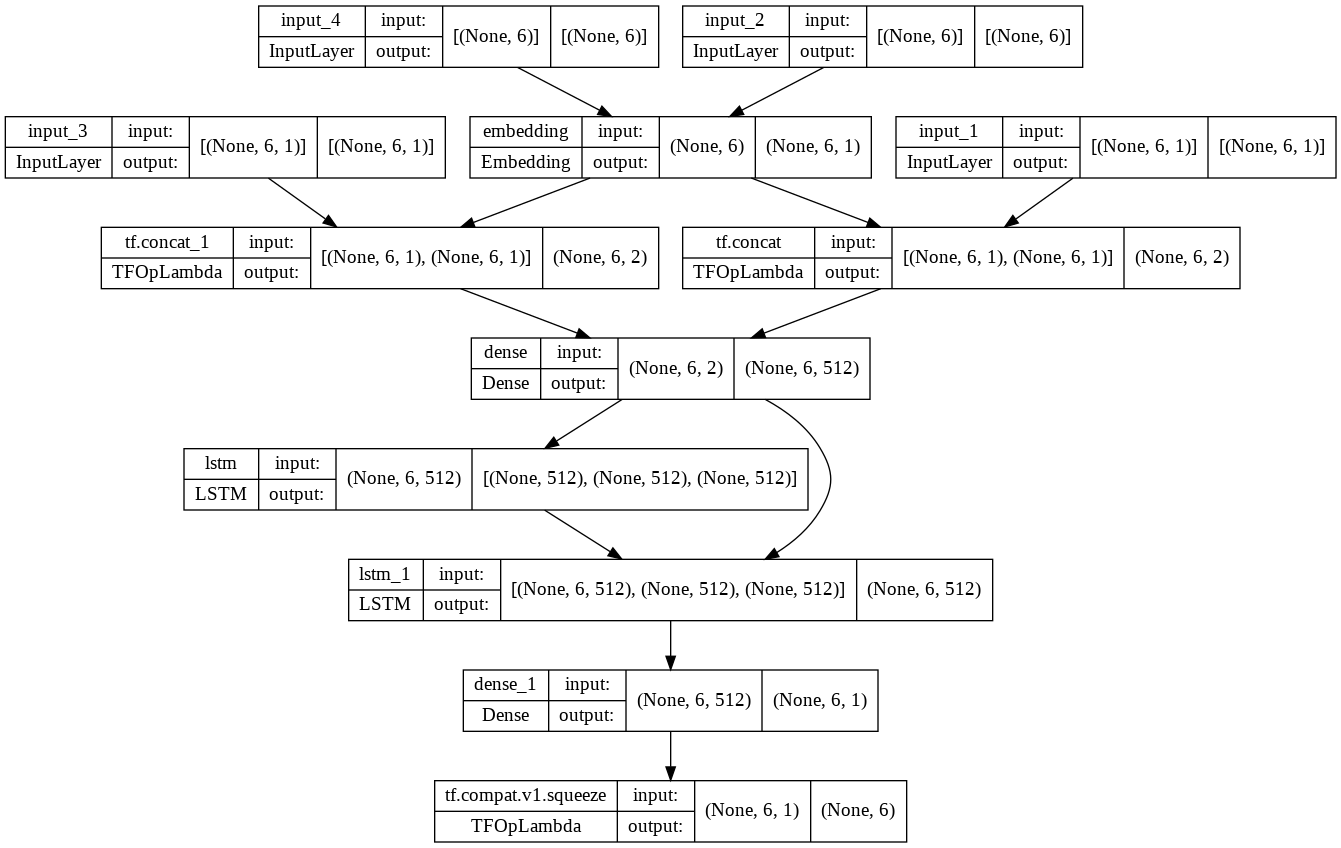

In [33]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [34]:
model.predict((train_enc_xs[:4], train_enc_ms[:4], train_dec_xs[:4], train_dec_ms[:4]))

array([[0.00385724, 0.00309237, 0.00450434, 0.00461177, 0.00479095,
        0.00234871],
       [0.00397813, 0.00508754, 0.00498062, 0.00500663, 0.00245753,
        0.00208561],
       [0.00618639, 0.0057869 , 0.00558852, 0.00286851, 0.00236925,
        0.00151772],
       [0.0052063 , 0.00509216, 0.00245171, 0.00201839, 0.00122175,
        0.00057689]], dtype=float32)

In [35]:
model.predict((test_enc_xs[:4], test_enc_ms[:4], test_dec_xs[:4], test_dec_ms[:4]))

array([[0.04270059, 0.03834554, 0.03421682, 0.03420735, 0.03569584,
        0.03768691],
       [0.04165551, 0.0365978 , 0.03588061, 0.03682413, 0.03840284,
        0.04182051],
       [0.03896882, 0.03758557, 0.03801587, 0.03919981, 0.04231156,
        0.04510948],
       [0.04316884, 0.04193831, 0.04190293, 0.04411373, 0.0462533 ,
        0.05046172]], dtype=float32)

## Train

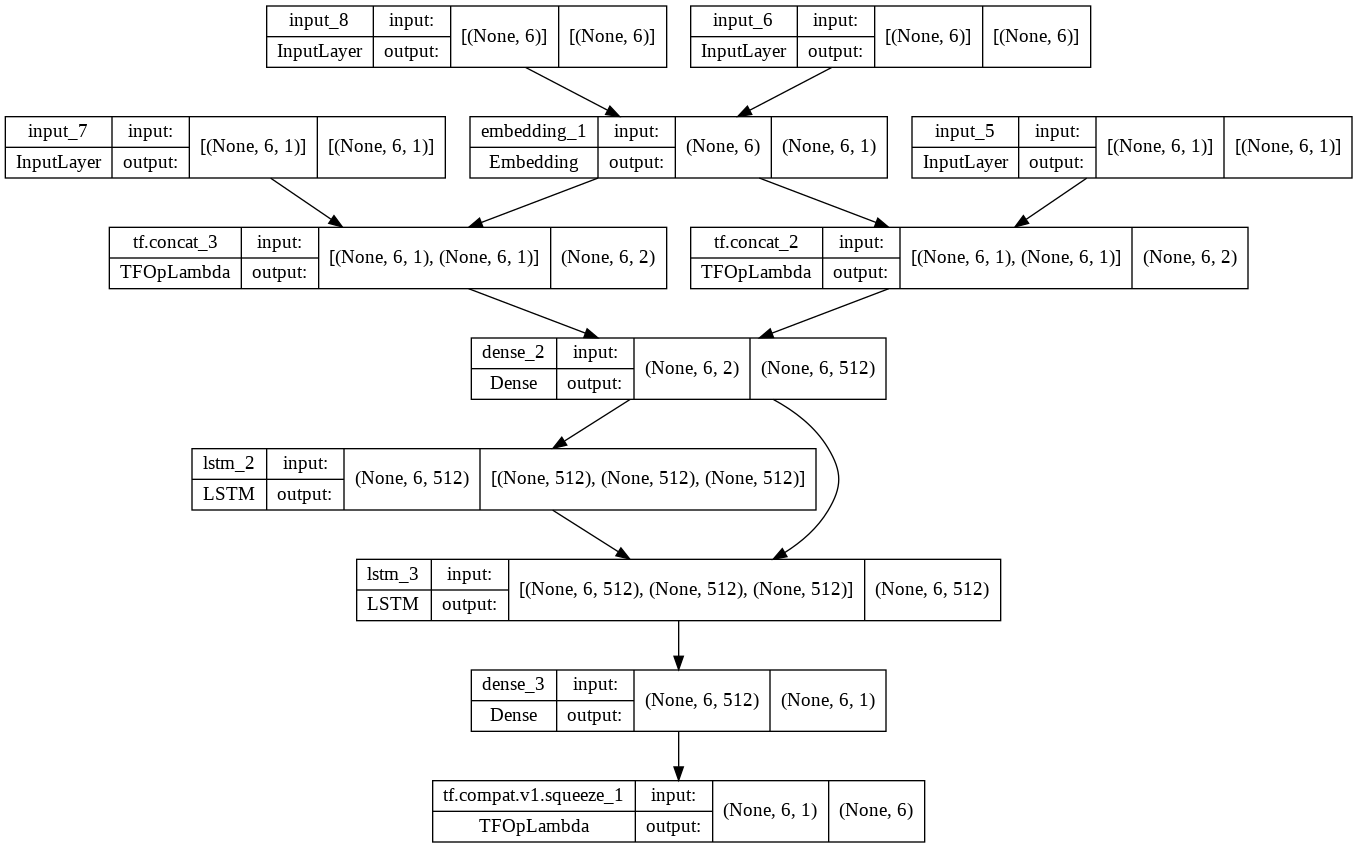

In [36]:
set_seed(args.seed)
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [37]:
model.compile(loss="mse", optimizer="adam")

In [38]:
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(passenger_dir, "rnn.hdf5"),
                                                  monitor='val_loss',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="min",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(passenger_dir, "rnn.csv"))

In [39]:
history = model.fit((train_enc_xs, train_enc_ms, train_dec_xs, train_dec_ms), train_dec_ys,
                    epochs=250,
                    batch_size=8,
                    validation_data=((test_enc_xs, test_enc_ms, test_dec_xs, test_dec_ms), test_dec_ys),
                    callbacks=[save_weights, csv_logger])

Epoch 1/250
13/14 [==========================>...] - ETA: 0s - loss: 0.0245
Epoch 1: val_loss improved from inf to 0.02046, saving model to /content/drive/MyDrive/문서/강의계획서/삼성전기/삼성전기.20220228/data/passenger/rnn.hdf5
14/14 [==============================] - 12s 157ms/step - loss: 0.0237 - val_loss: 0.0205
Epoch 2/250
13/14 [==========================>...] - ETA: 0s - loss: 0.0053
Epoch 2: val_loss improved from 0.02046 to 0.01207, saving model to /content/drive/MyDrive/문서/강의계획서/삼성전기/삼성전기.20220228/data/passenger/rnn.hdf5
14/14 [==============================] - 0s 29ms/step - loss: 0.0052 - val_loss: 0.0121
Epoch 3/250
13/14 [==========================>...] - ETA: 0s - loss: 0.0033
Epoch 3: val_loss improved from 0.01207 to 0.01086, saving model to /content/drive/MyDrive/문서/강의계획서/삼성전기/삼성전기.20220228/data/passenger/rnn.hdf5
14/14 [==============================] - 0s 29ms/step - loss: 0.0033 - val_loss: 0.0109
Epoch 4/2

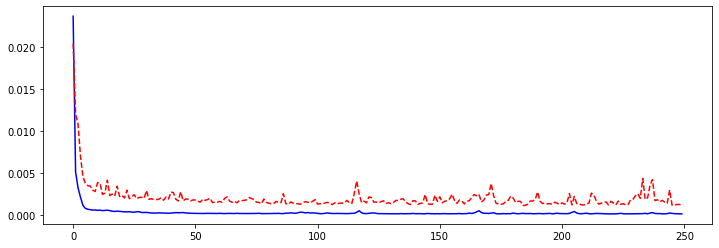

In [40]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 1, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.show()

## 평가

In [41]:
model = build_model(args)
model.load_weights(os.path.join(passenger_dir, "rnn.hdf5"))

In [42]:
model.compile(loss="mse", optimizer="adam")

In [43]:
model.evaluate((test_enc_xs, test_enc_ms, test_dec_xs, test_dec_ms), test_dec_ys)

1/1 [==============================] - 1s 924ms/step - loss: 0.0012


0.0011768649565055966

In [44]:
# train 예측
train_preds = model.predict((train_enc_xs, train_enc_ms, train_dec_xs, train_dec_ms))
train_preds[:, 0]

array([ 0.07588945,  0.08345646,  0.06380625,  0.03409744, -0.00185129,
        0.018835  ,  0.03250906,  0.02272861,  0.06295676,  0.06108492,
        0.05700771,  0.06790126,  0.10142206,  0.11929604,  0.09776021,
        0.07048009,  0.02549521,  0.04617011,  0.07493523,  0.07485779,
        0.11482205,  0.12553455,  0.11346842,  0.16386253,  0.17144811,
        0.18133762,  0.14952627,  0.11850082,  0.07788229,  0.11447523,
        0.13008788,  0.126146  ,  0.18218428,  0.16305974,  0.15484467,
        0.19931605,  0.24853647,  0.24044025,  0.21659899,  0.16509837,
        0.13019738,  0.17542064,  0.18811584,  0.17567453,  0.22662762,
        0.23890659,  0.25220427,  0.30086914,  0.31771445,  0.31359002,
        0.27159607,  0.21603656,  0.16873315,  0.20255181,  0.20822114,
        0.19335932,  0.22253343,  0.24033362,  0.24136633,  0.30844083,
        0.3506067 ,  0.37166438,  0.30595705,  0.25324833,  0.20134076,
        0.25215125,  0.26198953,  0.25951025,  0.31398702,  0.30

In [45]:
scale_labels = scaler_dic['Passengers'].inv_scale_value(train_dec_ys[:, -1])
scale_labels

array([118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337.])

In [46]:
scale_preds = scaler_dic['Passengers'].inv_scale_value(train_preds[:, -1])
scale_preds

array([120.645355, 127.233826, 119.79223 , 147.41423 , 140.8865  ,
       135.54575 , 140.222   , 155.49196 , 165.52849 , 153.71841 ,
       139.95326 , 120.0531  , 132.26247 , 145.89429 , 144.89679 ,
       173.05661 , 172.66116 , 164.47076 , 185.89066 , 190.824   ,
       195.88162 , 179.642   , 164.06476 , 145.88852 , 164.9056  ,
       173.29532 , 170.318   , 204.97273 , 192.28607 , 185.24384 ,
       205.05095 , 230.02995 , 228.4638  , 213.37085 , 189.03665 ,
       171.19196 , 192.39893 , 200.51898 , 194.85217 , 226.20346 ,
       228.90042 , 234.98097 , 257.69693 , 265.5333  , 262.70566 ,
       240.541   , 214.39435 , 191.69572 , 206.85251 , 210.93379 ,
       204.42334 , 226.34169 , 230.77313 , 232.71237 , 265.4817  ,
       286.03326 , 293.89032 , 259.4632  , 232.33347 , 207.57877 ,
       227.93584 , 236.02827 , 236.68405 , 270.07233 , 263.37766 ,
       272.9864  , 308.46378 , 340.5254  , 353.37048 , 305.2248  ,
       276.85535 , 247.79347 , 266.57925 , 282.10046 , 277.206

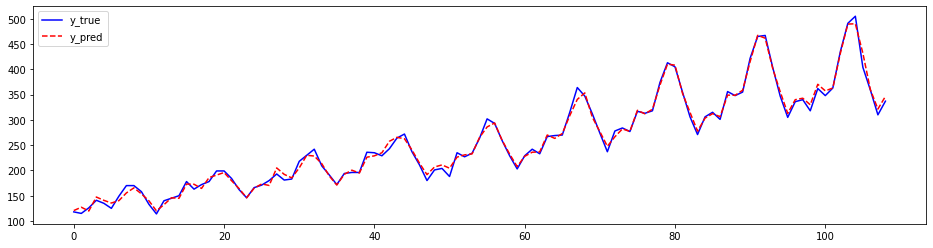

In [47]:
plt.figure(figsize=(16, 4))
plt.plot(scale_labels, 'b-', label='y_true')
plt.plot(scale_preds, 'r--', label='y_pred')
plt.legend()
plt.show()

In [48]:
rmse = tf.sqrt(tf.keras.losses.MSE(scale_labels, scale_preds))
rmse

<tf.Tensor: shape=(), dtype=float32, numpy=7.6998262>

In [49]:
# test 예측
test_preds = model.predict((test_enc_xs, test_enc_ms, test_dec_xs, test_dec_ms))
test_preds[:, 0]

array([0.47572058, 0.47229046, 0.5648184 , 0.5703172 , 0.5867431 ,
       0.7465005 , 0.8284521 , 0.86966395, 0.74807376, 0.603418  ,
       0.5113316 , 0.59978867, 0.60587126, 0.57782   , 0.6737402 ,
       0.60693353, 0.71384966, 0.8697412 , 0.9695086 ], dtype=float32)

In [50]:
scale_labels = scaler_dic['Passengers'].inv_scale_value(test_dec_ys[:, -1])
scale_labels

array([472., 548., 559., 463., 407., 362., 405., 417., 391., 419., 461.,
       472., 535., 622., 606., 508., 461., 390., 432.])

In [51]:
scale_preds = scaler_dic['Passengers'].inv_scale_value(test_preds[:, -1])
scale_preds

array([490.07968, 531.2744 , 543.2376 , 476.25266, 405.43747, 361.11002,
       397.4965 , 406.6597 , 395.84625, 443.69937, 409.31998, 462.95953,
       550.2457 , 602.1664 , 618.7685 , 515.57294, 439.162  , 402.2268 ,
       429.06833], dtype=float32)

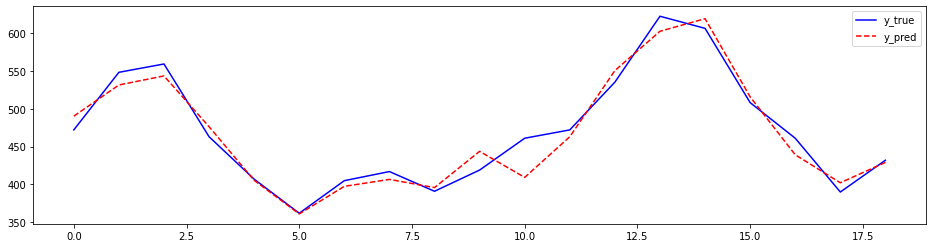

In [52]:
plt.figure(figsize=(16, 4))
plt.plot(scale_labels, 'b-', label='y_true')
plt.plot(scale_preds, 'r--', label='y_pred')
plt.legend()
plt.show()

In [53]:
rmse = tf.sqrt(tf.keras.losses.MSE(scale_labels, scale_preds))
rmse

<tf.Tensor: shape=(), dtype=float32, numpy=17.86564>